# Penalized regression approaches for time series representation
Penalized regression approaches are useful to have better predictions in time series classifications. In this project i will be using fused lasso 1D and tree regression methods to have different penalized regression approaches for 1NN classification problem. In the end raw model and penalized models will be compared in terms of accuracy.
                                                                                            
                                                                                            Alperen Köksal

In [16]:
library(data.table,quietly = TRUE,warn.conflicts = FALSE)
library(ggplot2,quietly = TRUE,warn.conflicts = FALSE)
library(lubridate,quietly = TRUE,warn.conflicts = FALSE)
library(forecast,quietly = TRUE,warn.conflicts = FALSE)
library(urca,quietly = TRUE,warn.conflicts = FALSE)
library(plotly,quietly = TRUE,warn.conflicts = FALSE)
library(scatterplot3d,quietly = TRUE,warn.conflicts = FALSE)
library(rpart,quietly = TRUE,warn.conflicts = FALSE)
library(rattle,quietly = TRUE,warn.conflicts = FALSE)
library(genlasso,quietly = TRUE,warn.conflicts = FALSE)
library(modelr)
library(resamplr)
library(caret)

In [17]:
setwd("C:/Users/a_kok/Desktop/Dersler/IE 48B/HW2")
cbf_train = fread("CBF_TRAIN.txt")
setnames(cbf_train,"V1","class")


In [18]:
cbf_train[,id:=1:.N]
cbf_train = cbf_train[order(class)]
cbf_train[,class:=as.character(class)]
cbf_train = cbf_train[order(id,class)]
long_cbf_train = melt(cbf_train,id.vars=c('id','class'))
long_cbf_train[,time:=as.numeric(gsub("\\D", "", variable))-1]
long_cbf_train=long_cbf_train[,list(id,class,time,value)]
long_cbf_train=long_cbf_train[order(id,time)]
traindata <- cbf_train[,2:(ncol(cbf_train)-1)]
trainclass <- cbf_train[,1]

#### 1-
For each training set fussedlasso1d representation is created.
To get the best lambda parameter cv.trendfilter method is used which performs k fold cross validation.

In [4]:
lasso_fits <- list()
cvs <- list()

for(i in 1:30){
lasso_fits[[i]] = fusedlasso1d(y = as.matrix(traindata[i]))
cvs[[i]] = cv.trendfilter(lasso_fits[[i]],k = 10) 
}

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 10 ... 
Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... Fold 6 ... Fold 7 ... Fold 8 ... Fold 9 ... Fold 

In [5]:
for(i in 1:30){
long_cbf_train[id == i,"predicted_lasso"] = as.numeric(predict(lasso_fits[[i]],traindata[i],lambda = cvs[[i]]$lambda.min)$fit)
}

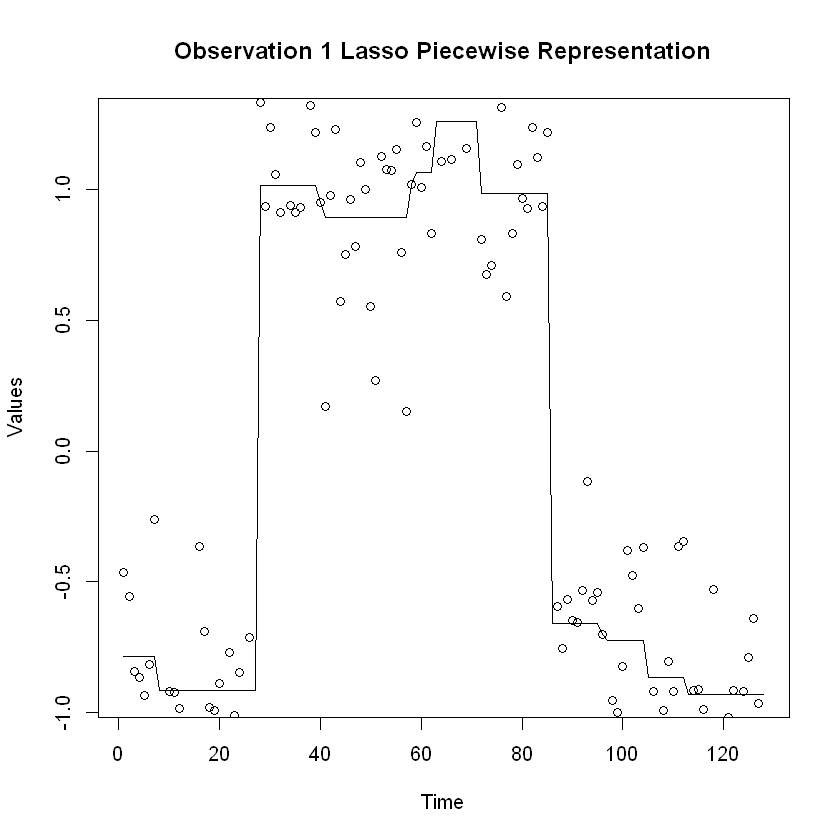

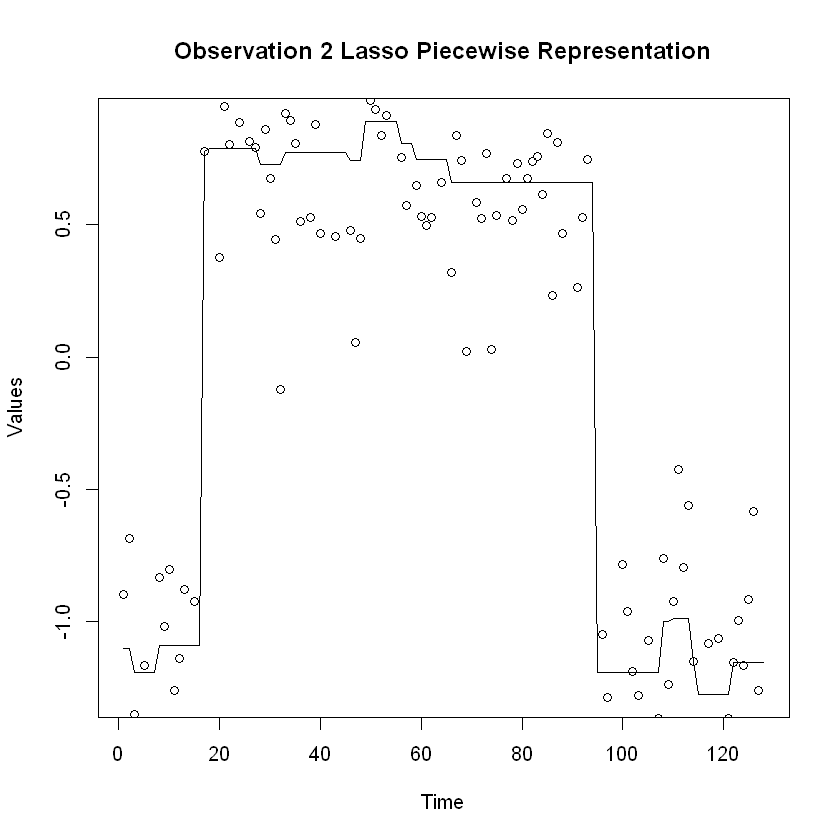

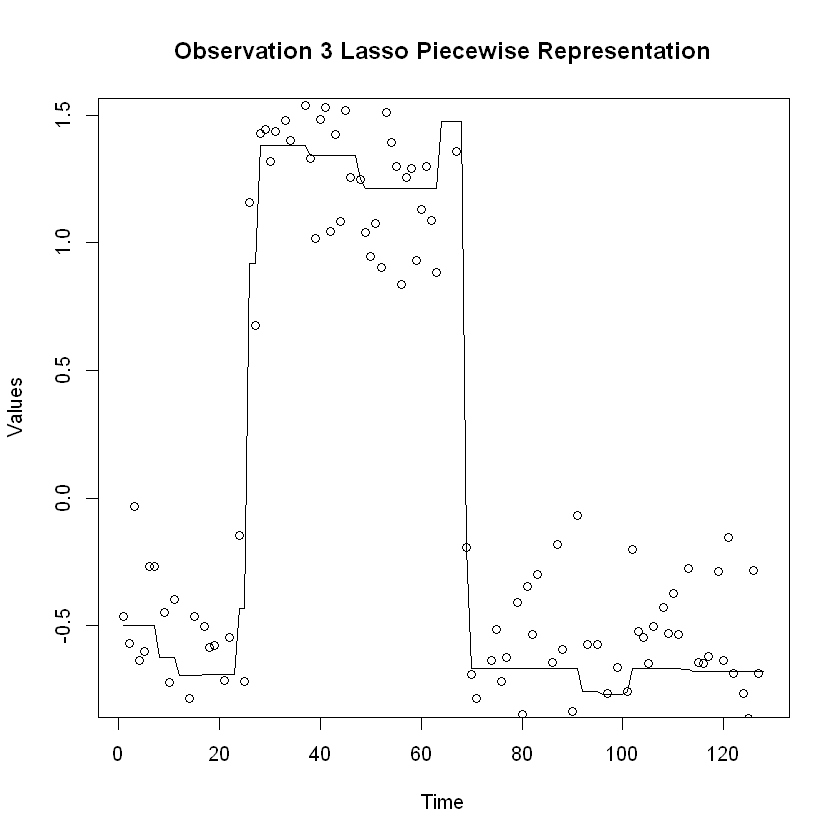

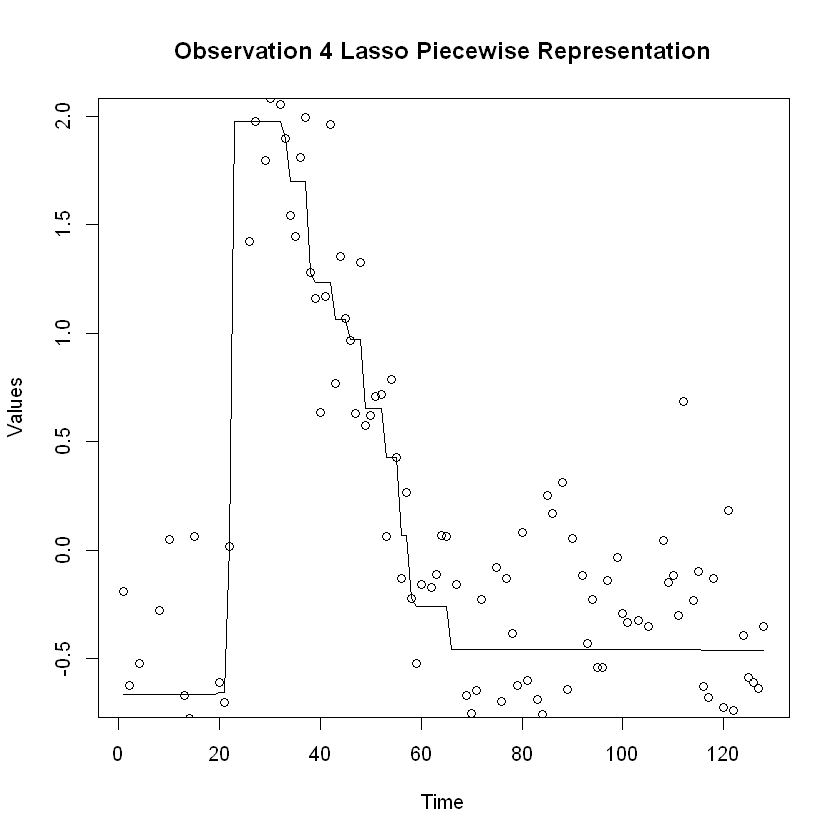

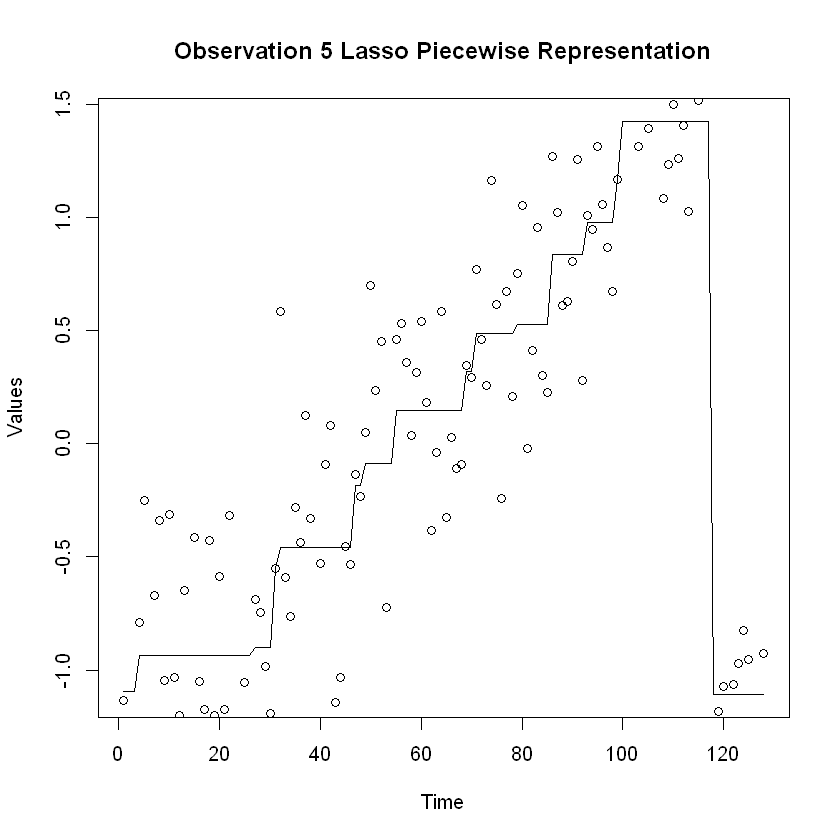

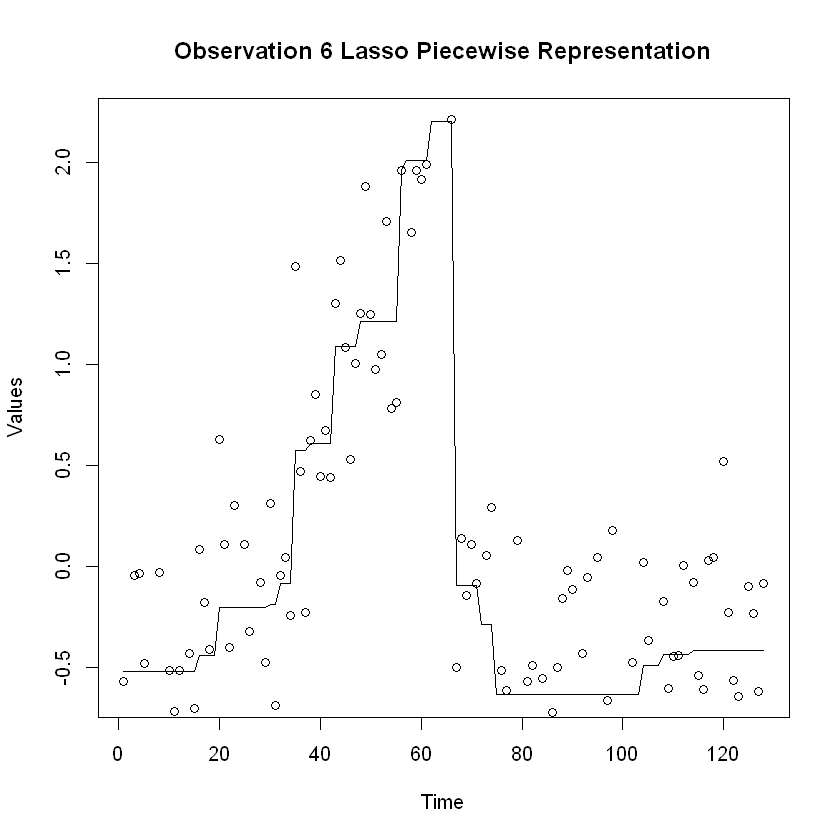

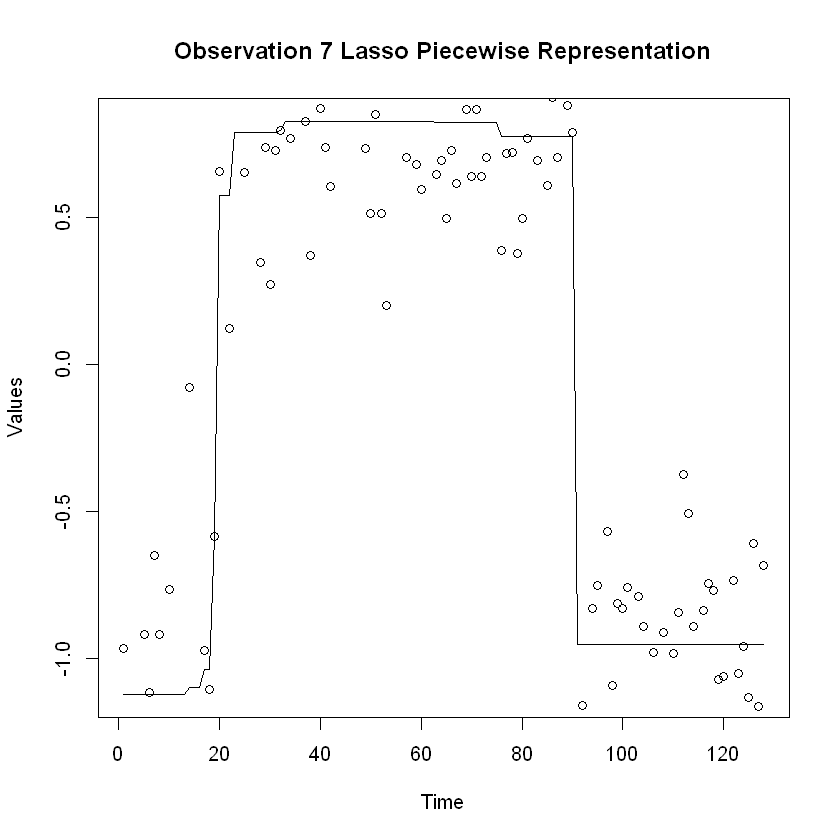

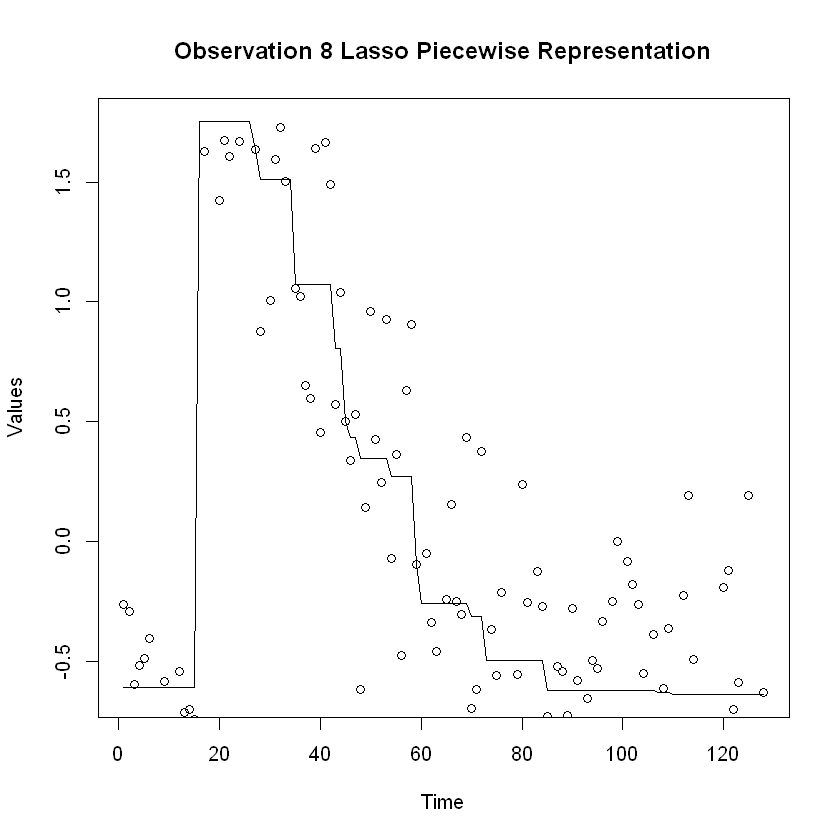

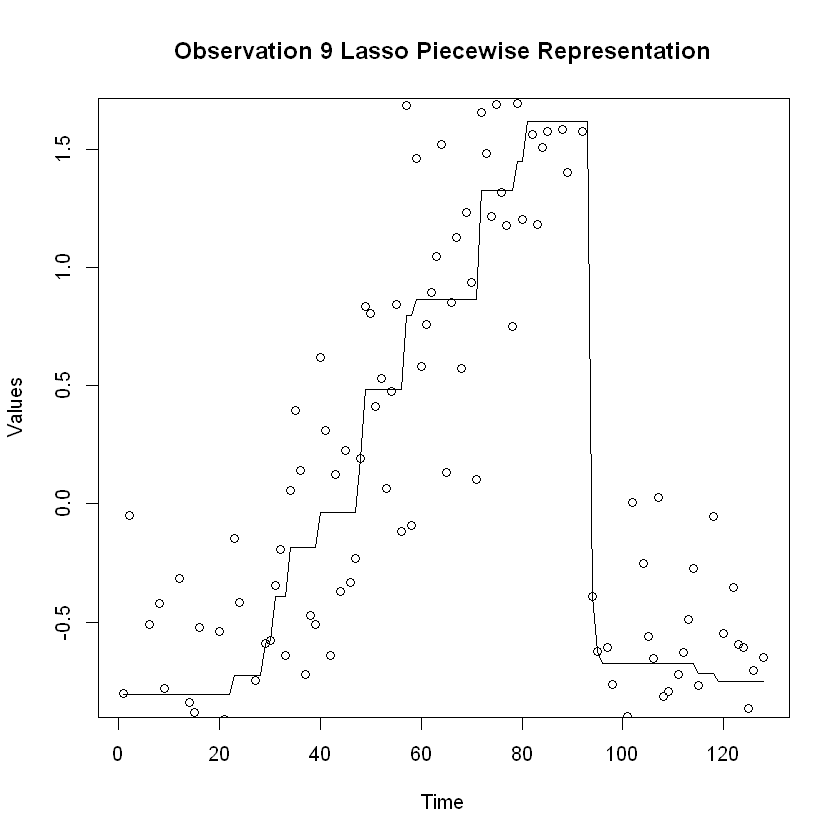

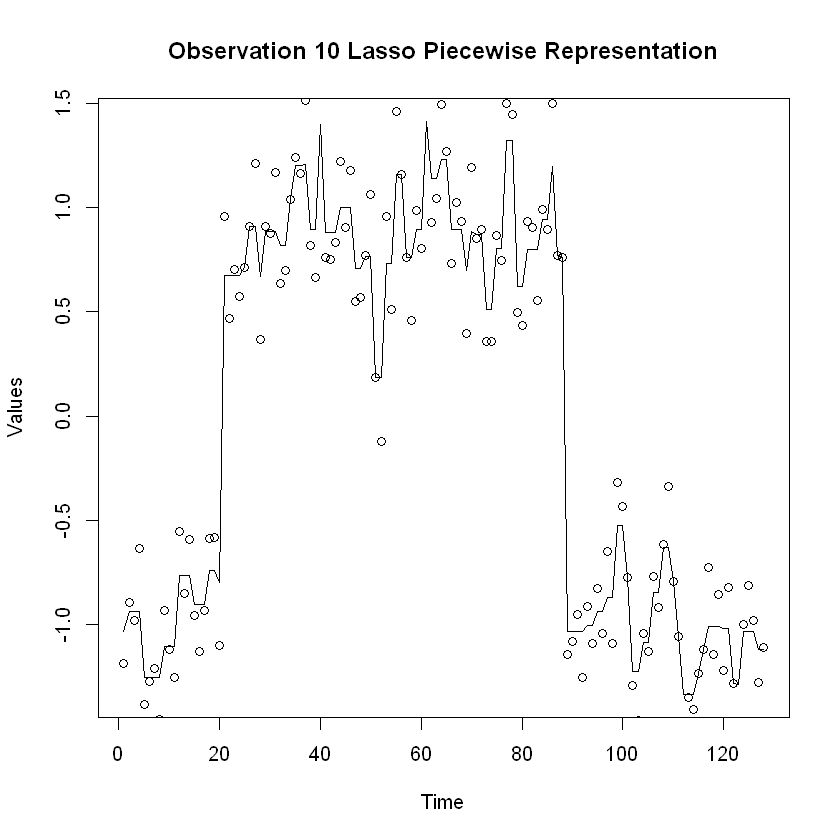

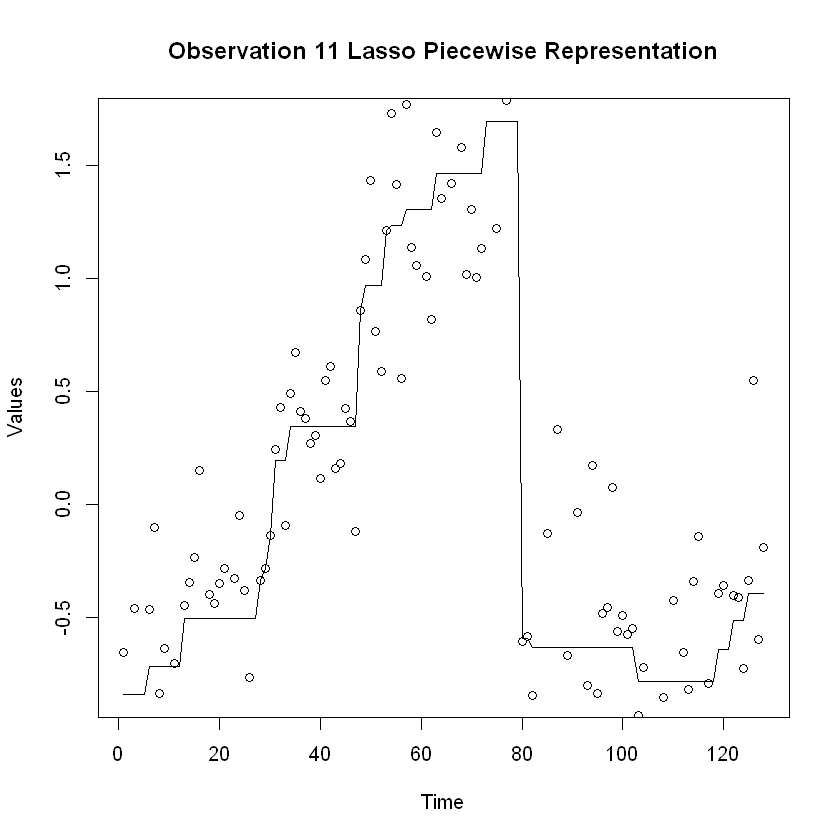

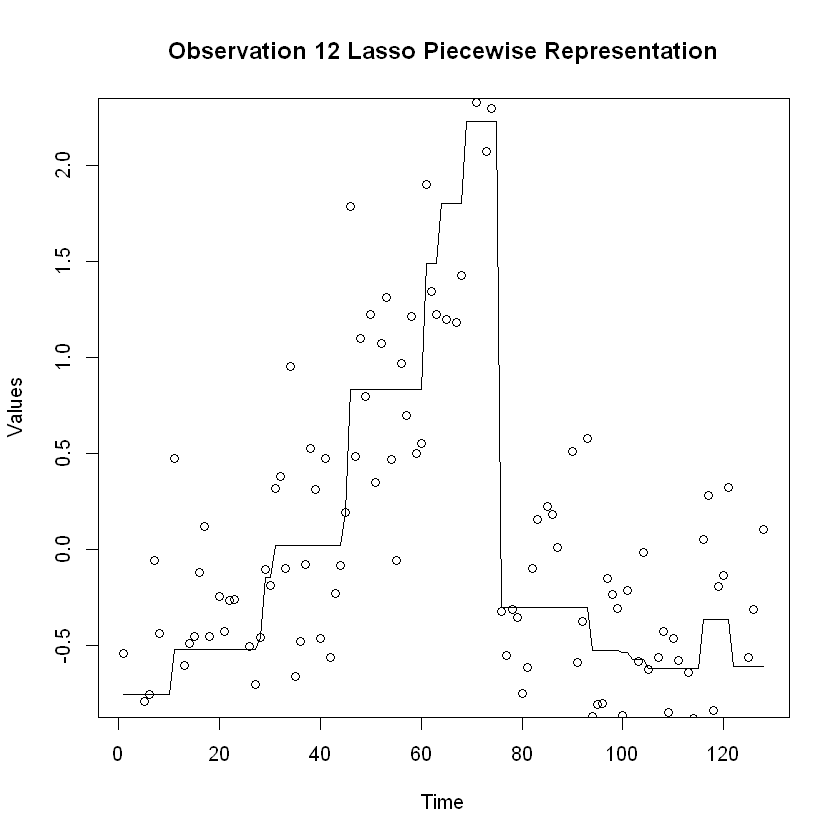

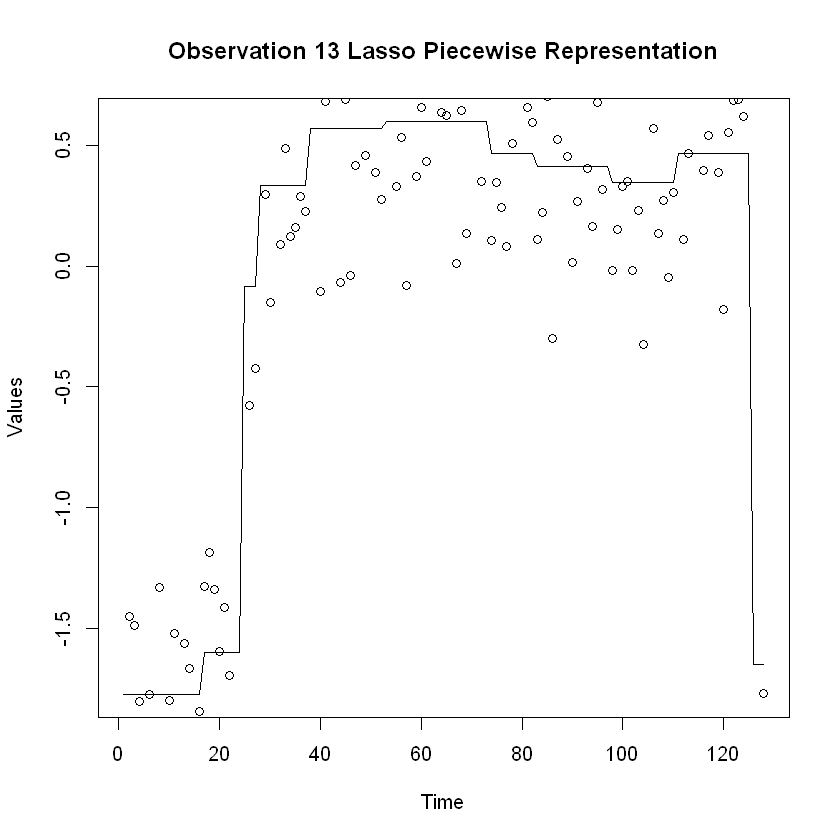

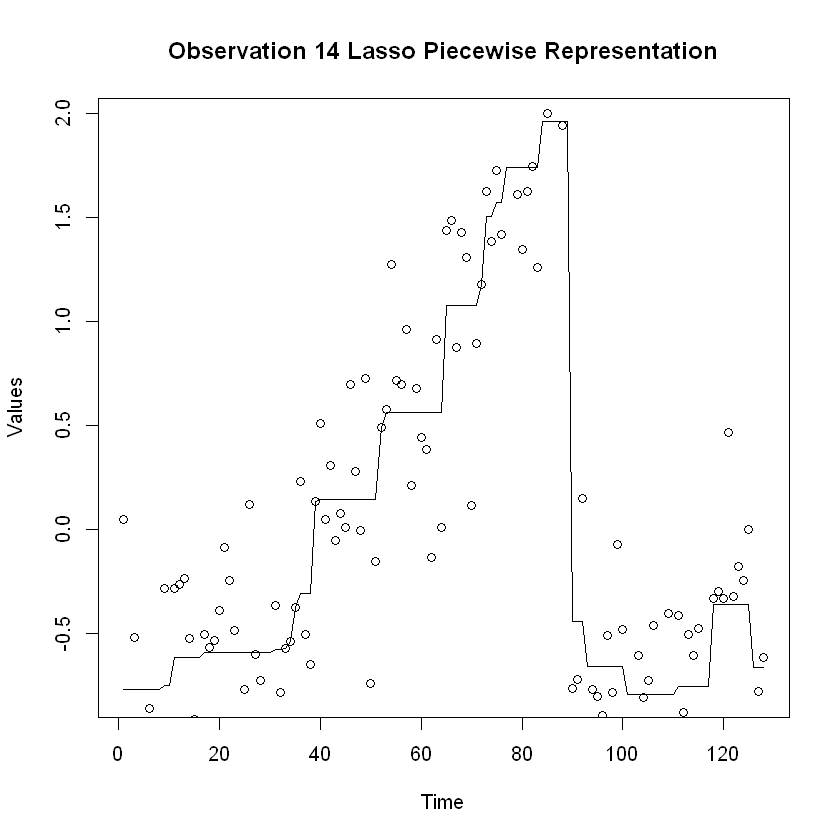

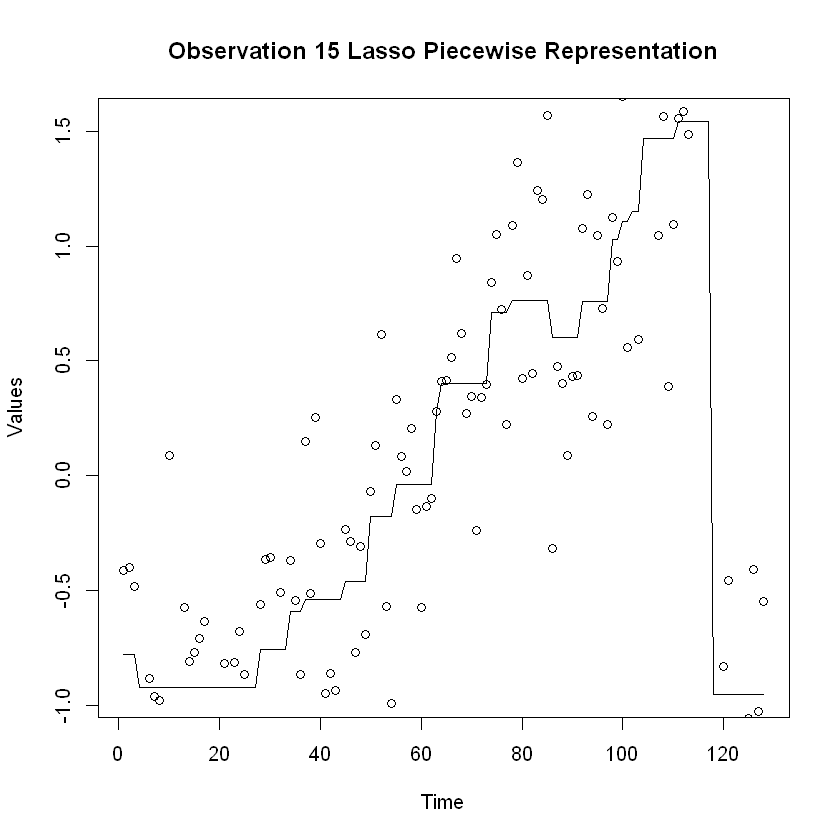

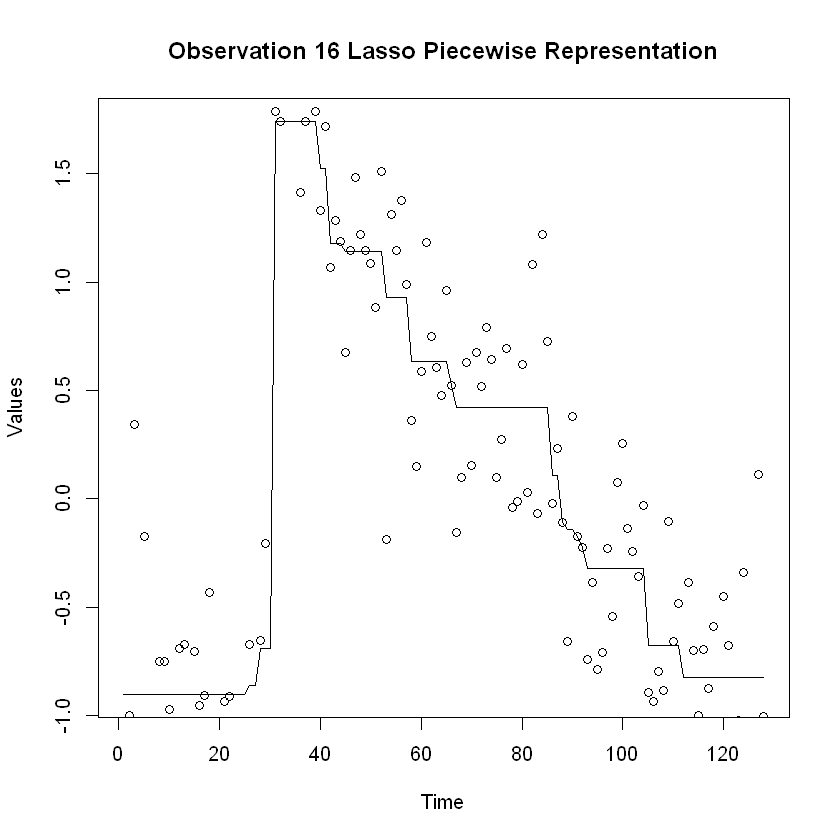

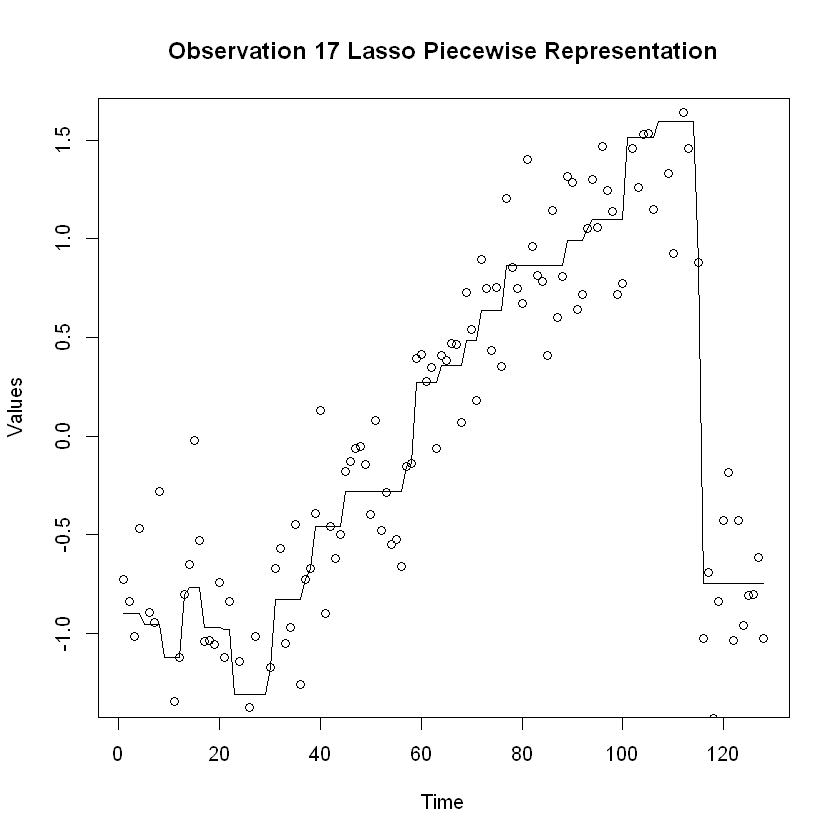

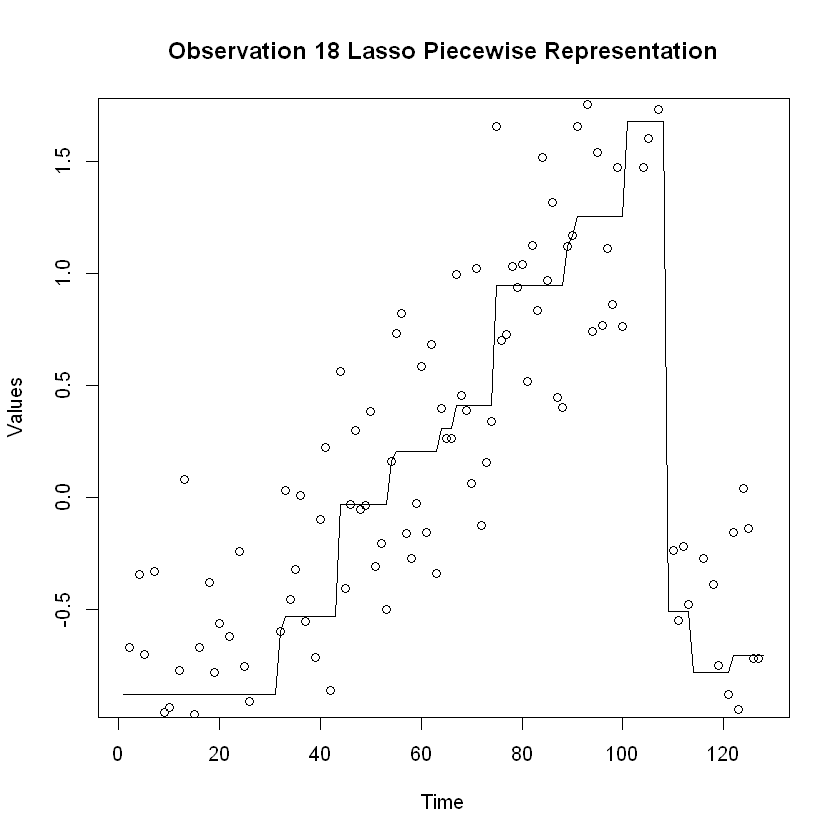

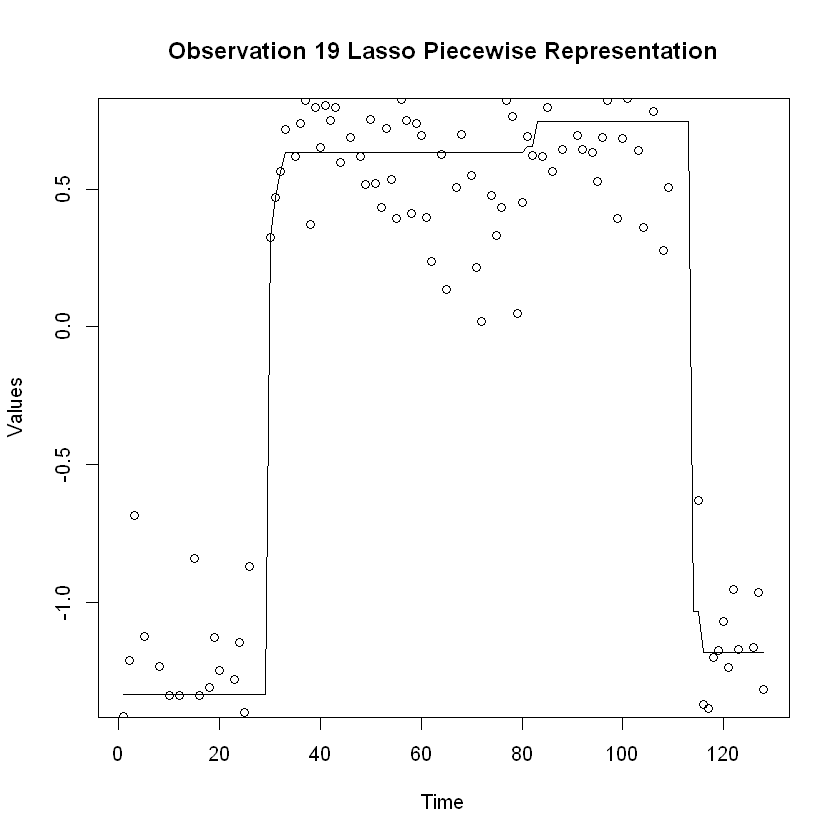

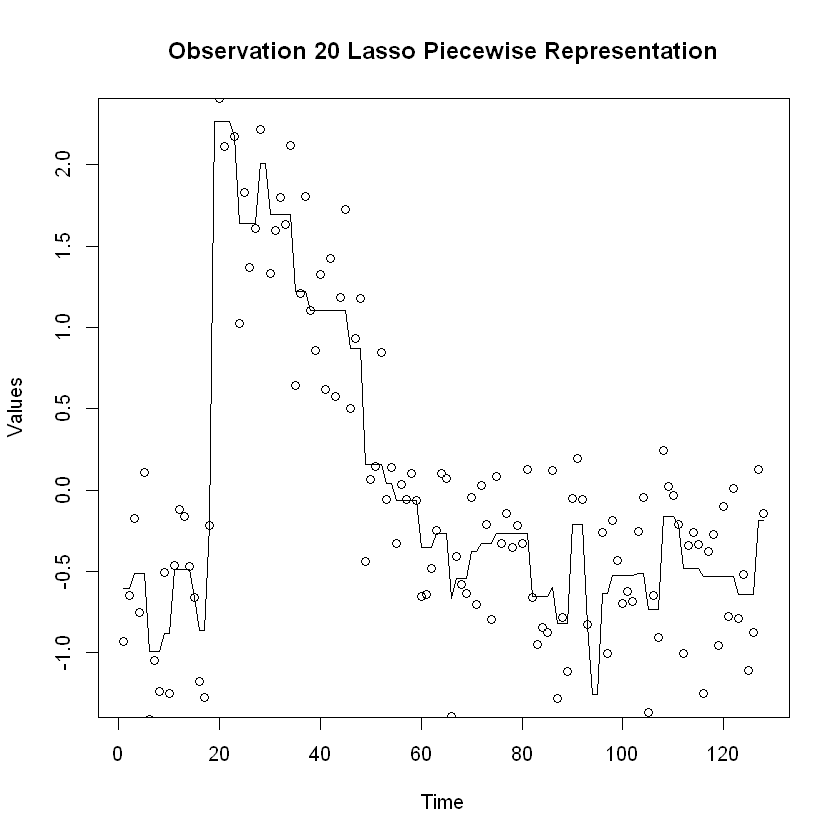

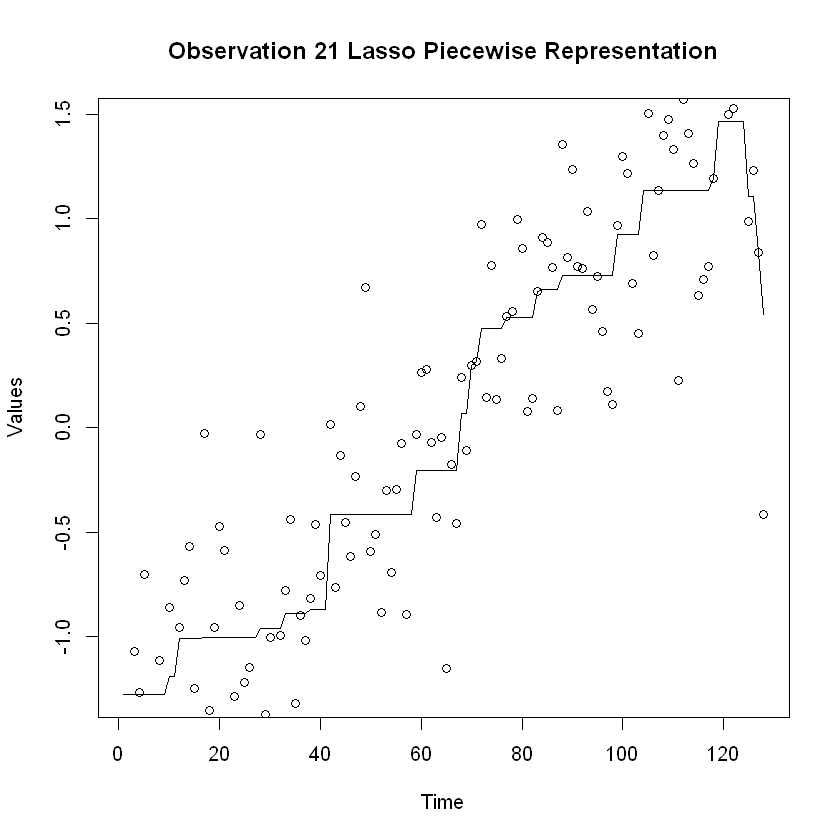

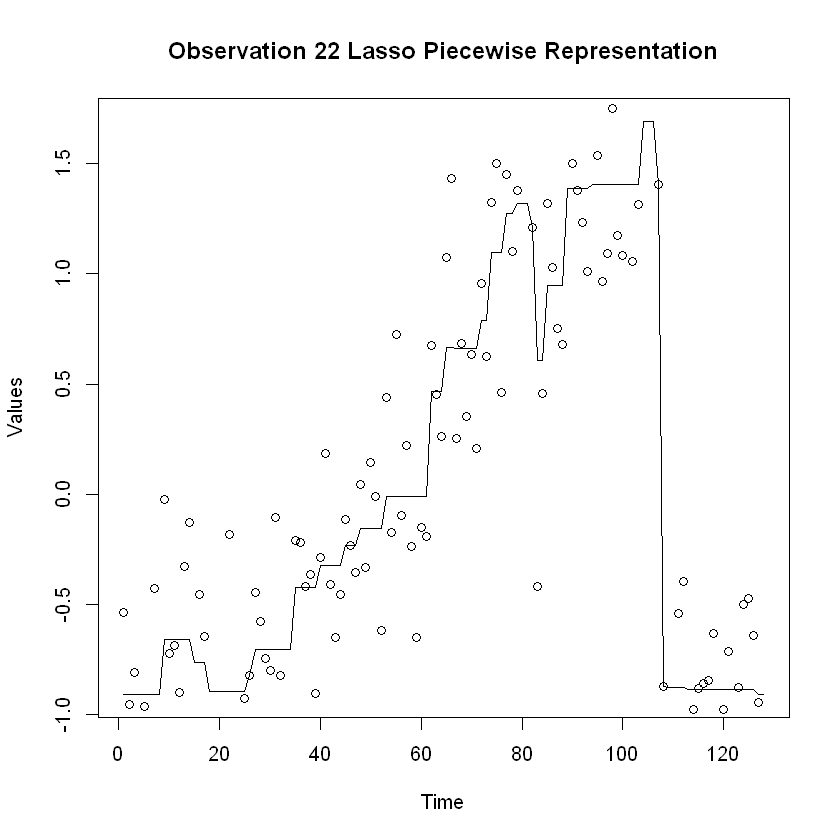

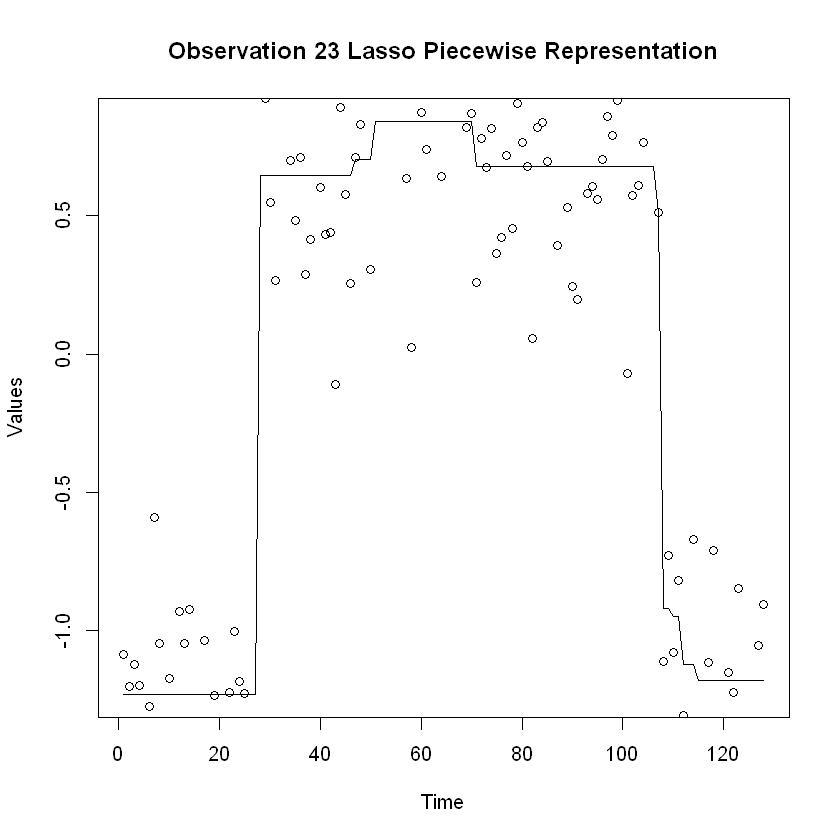

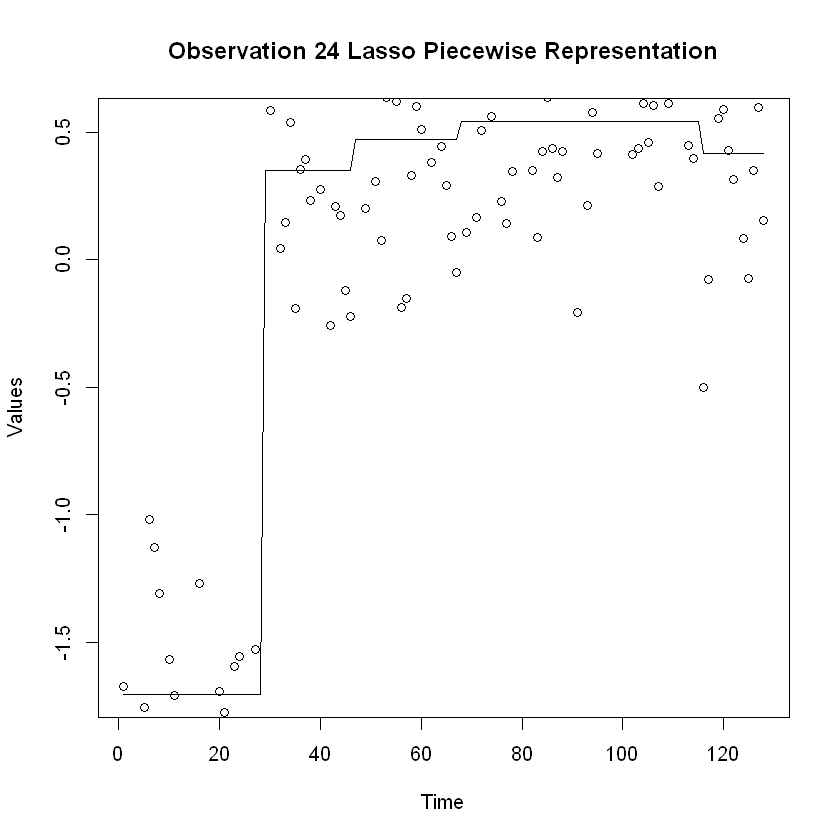

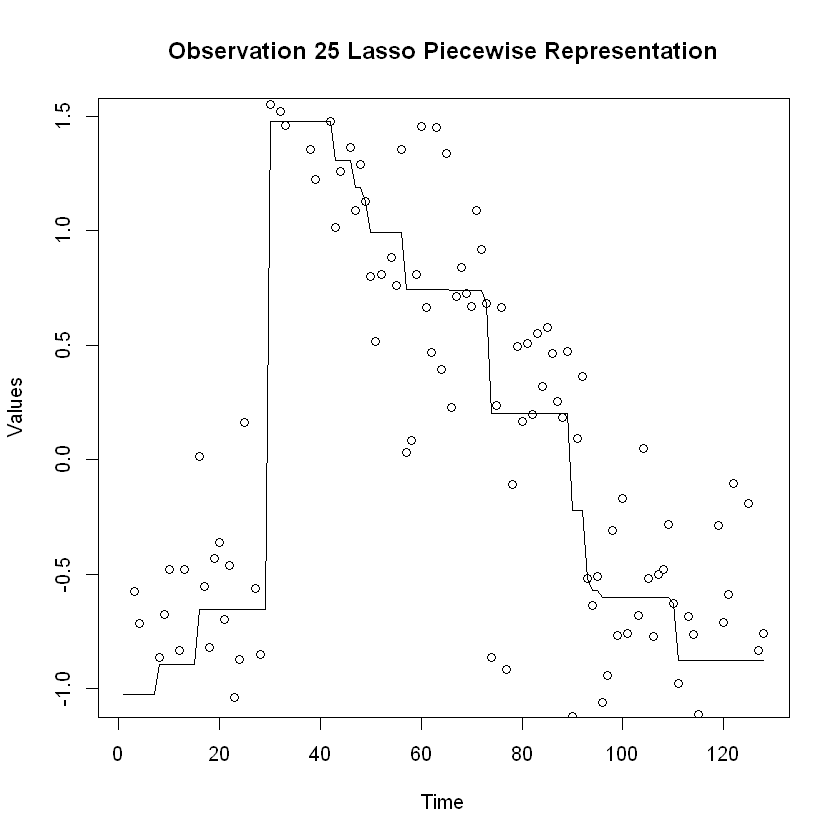

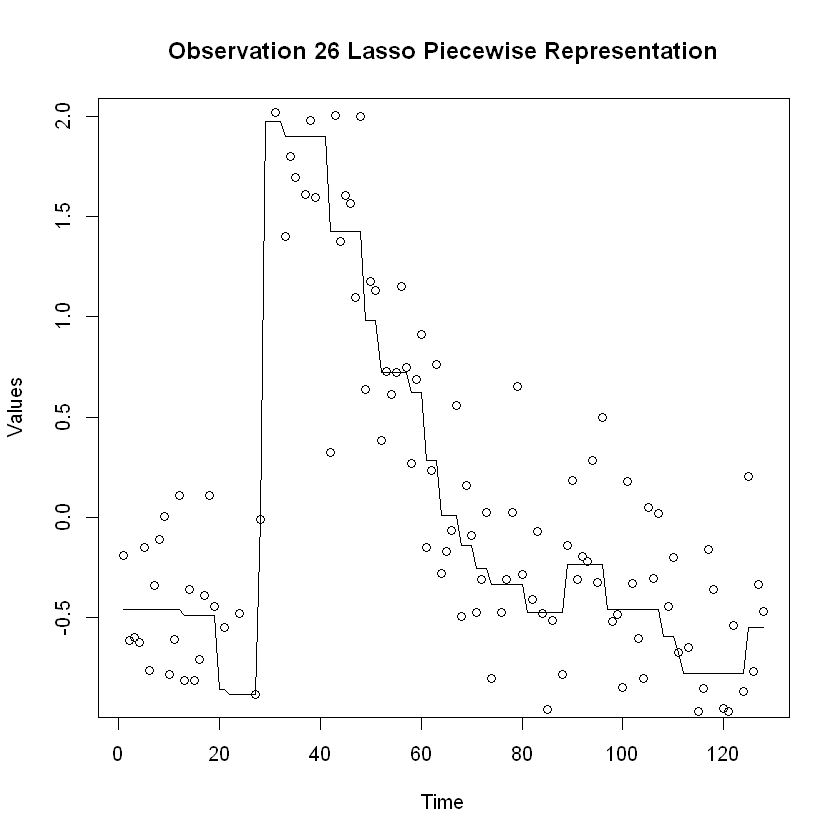

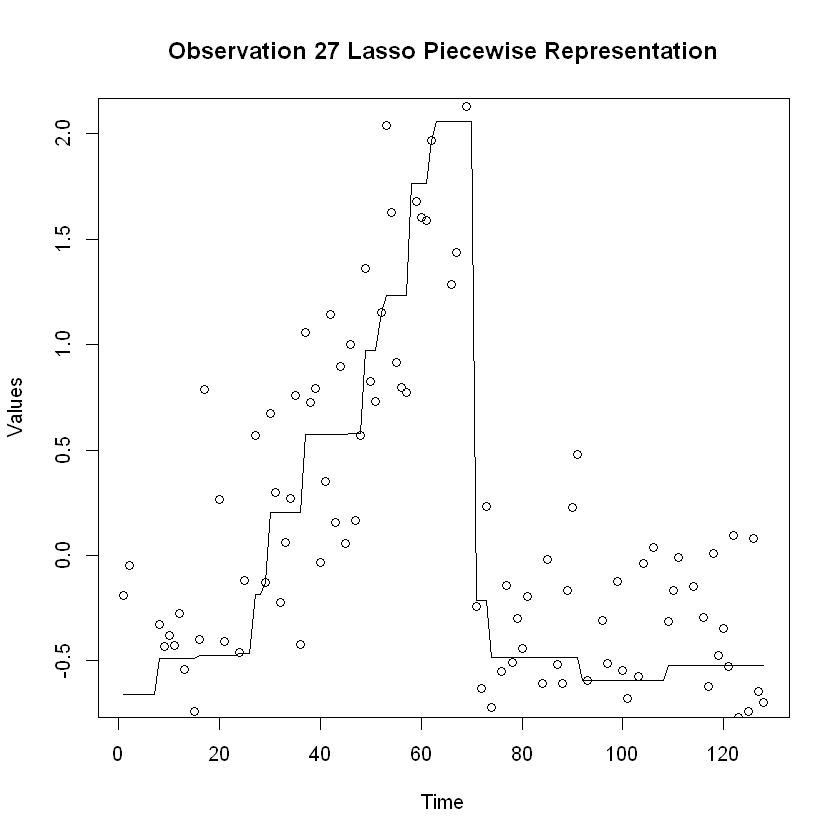

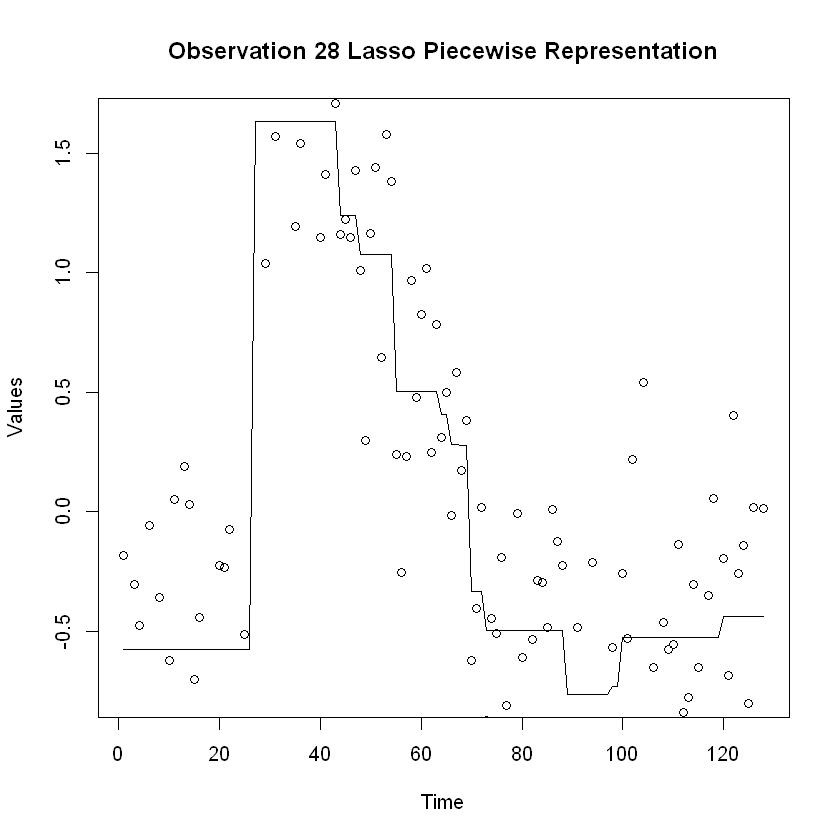

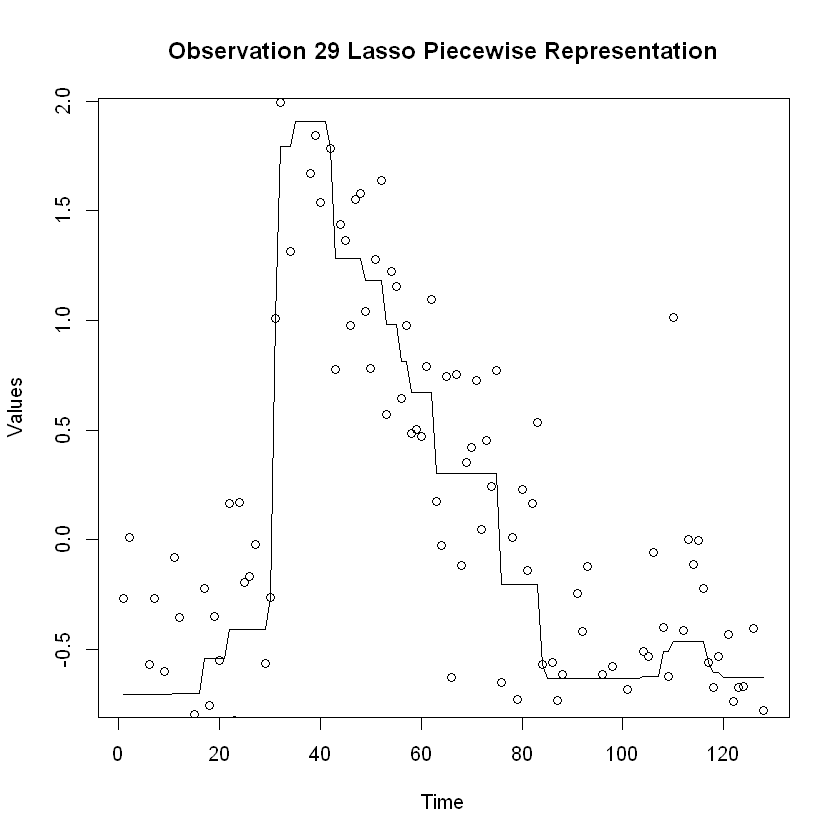

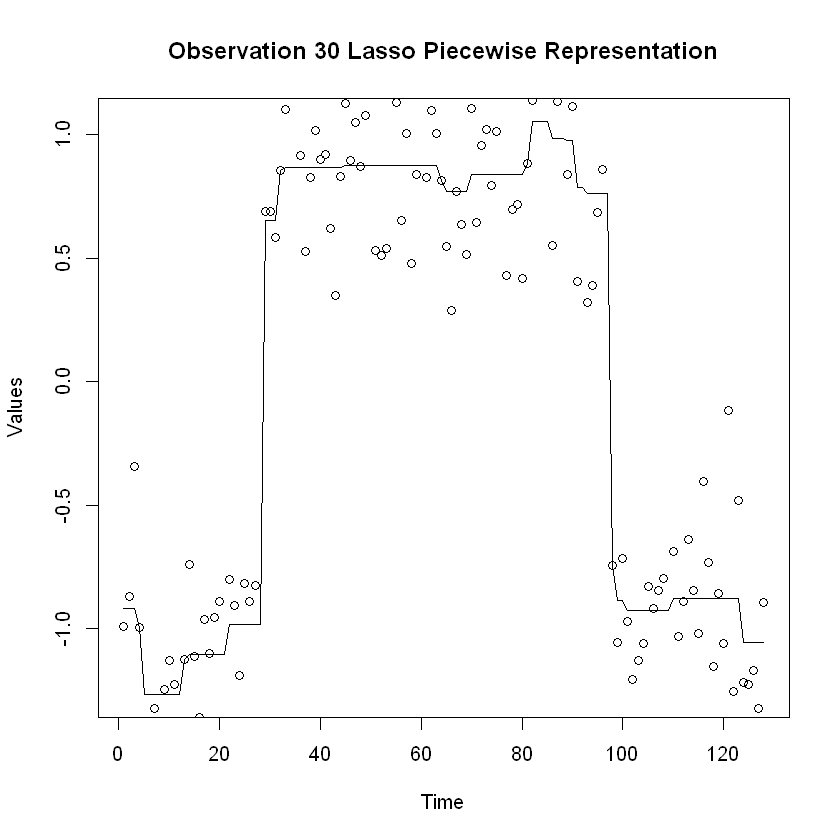

In [6]:
for ( i in 1:30){
    plot(long_cbf_train[id == i]$time,long_cbf_train[id == i]$predicted_lasso,type = "l",xlab = "Time",ylab = "Values",
         main = paste("Observation",toString(i),"Lasso Piecewise Representation"))
    points(long_cbf_train[id == i]$value)
}

#### 2-
For each training set regression tree representation is created. To get the best maximum depth parameter k out sampling method is used which is introduced in homework description

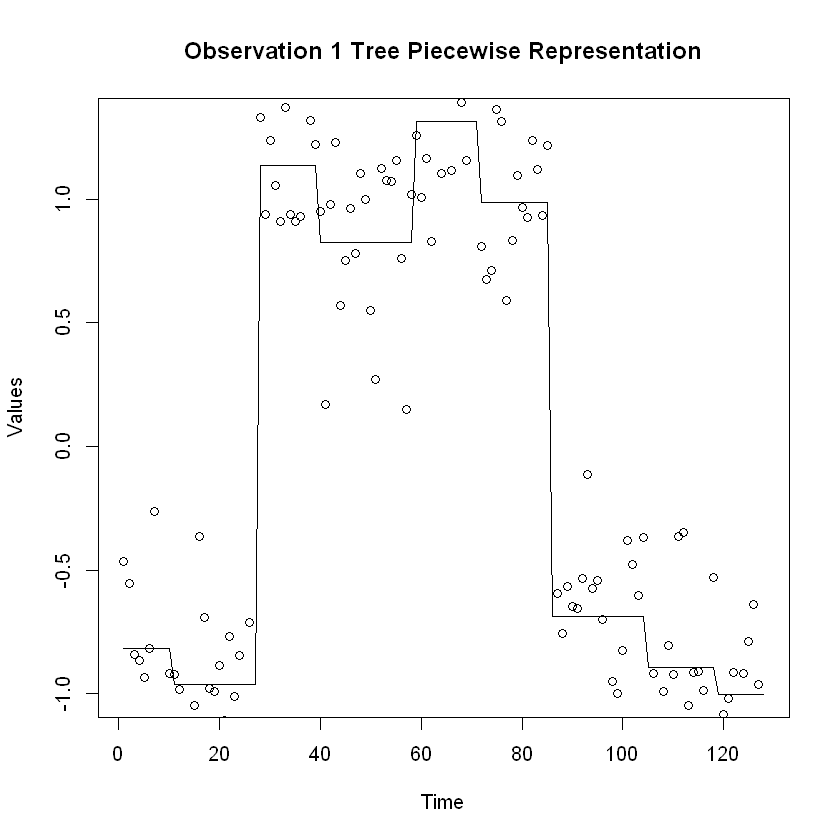

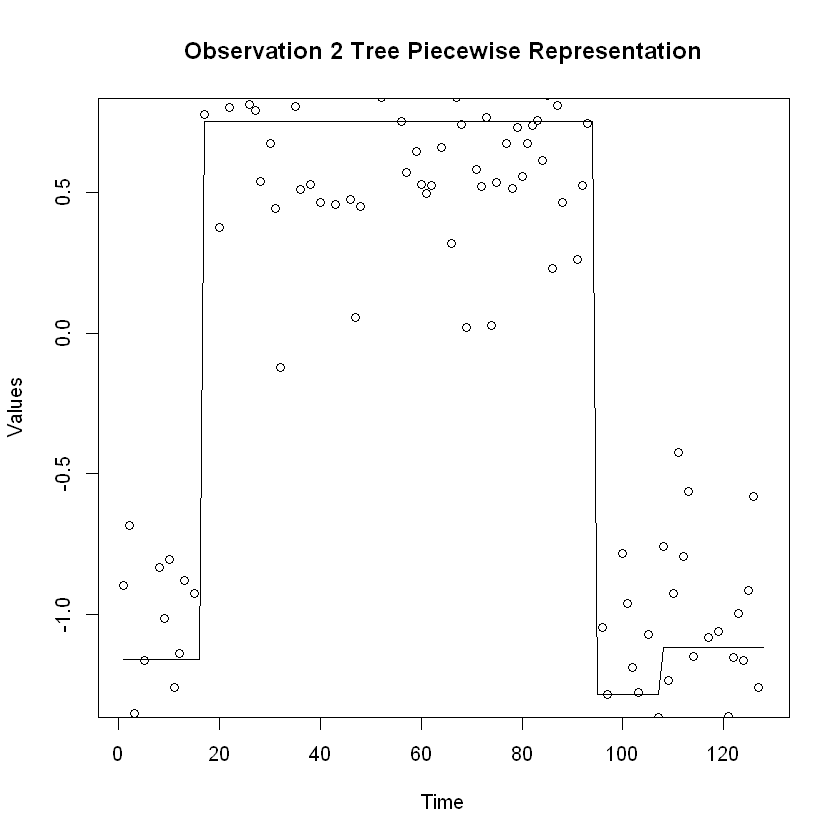

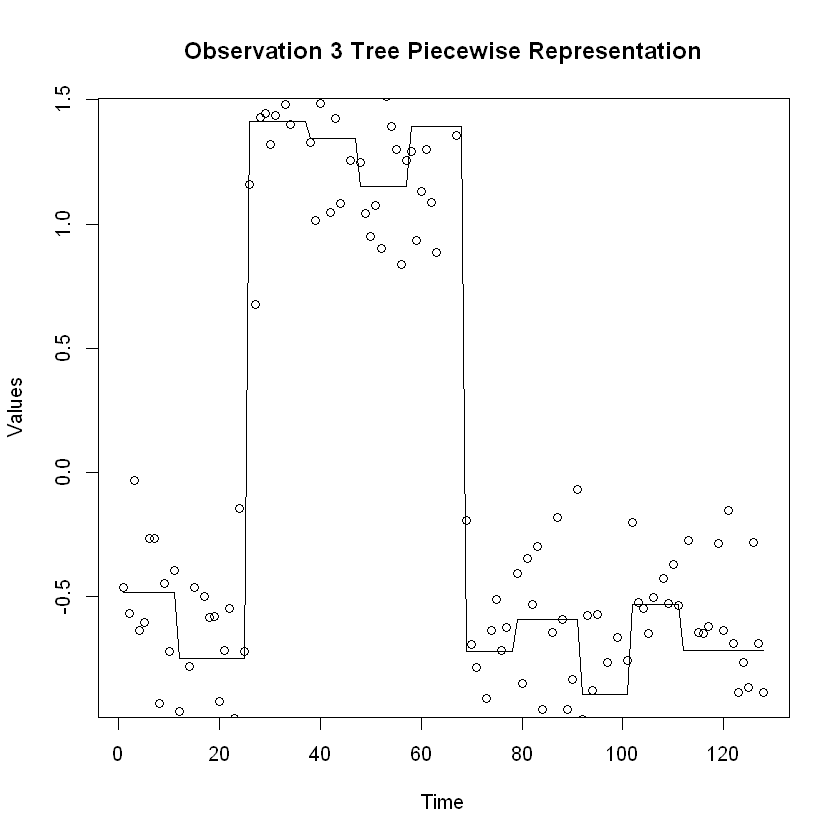

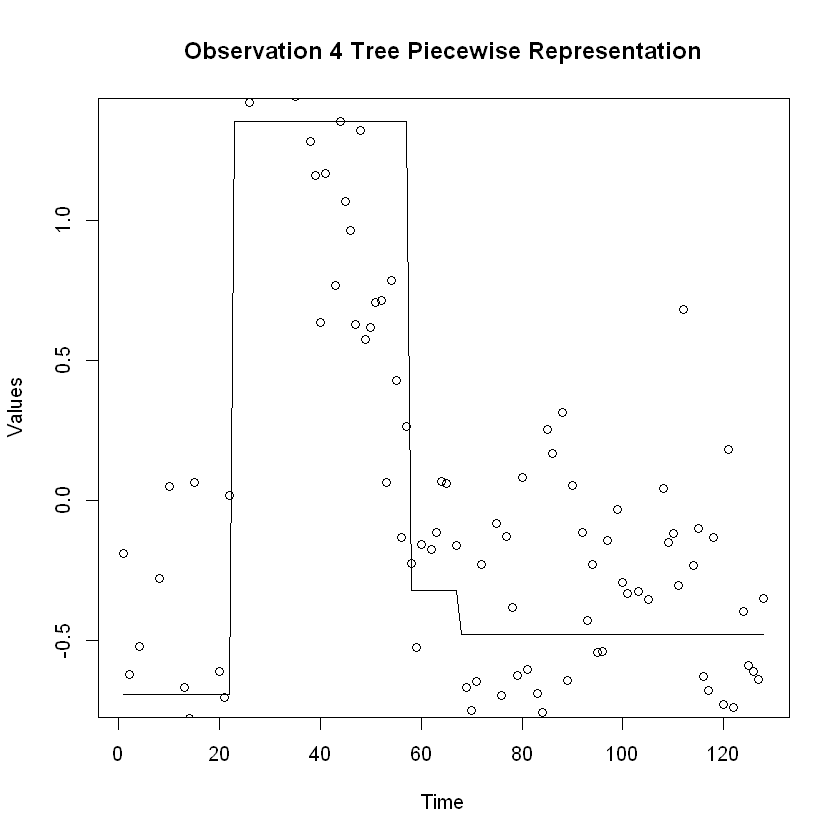

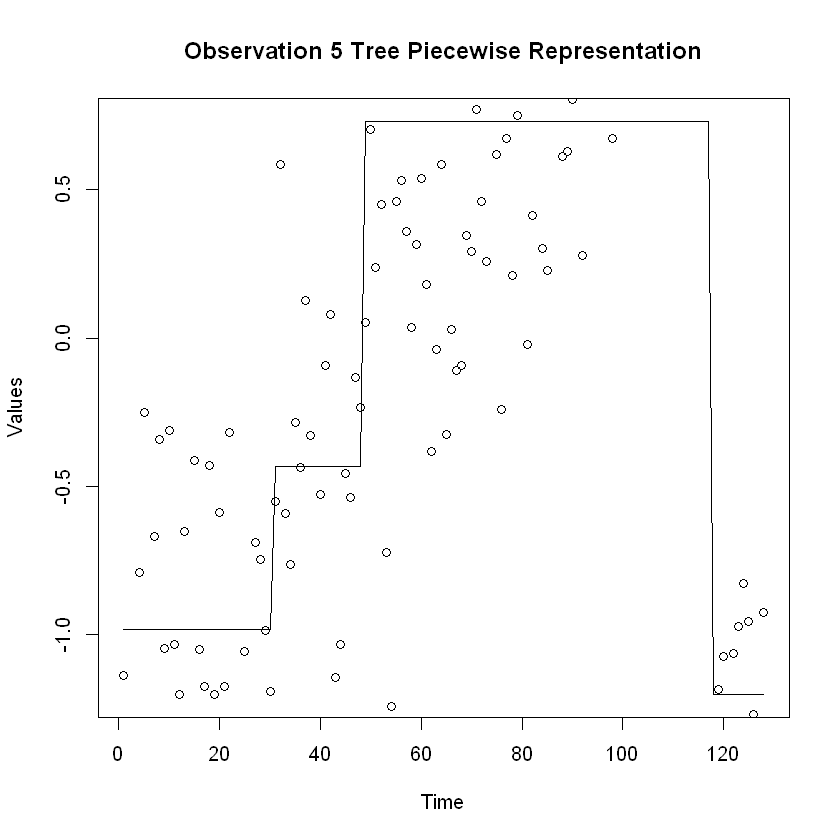

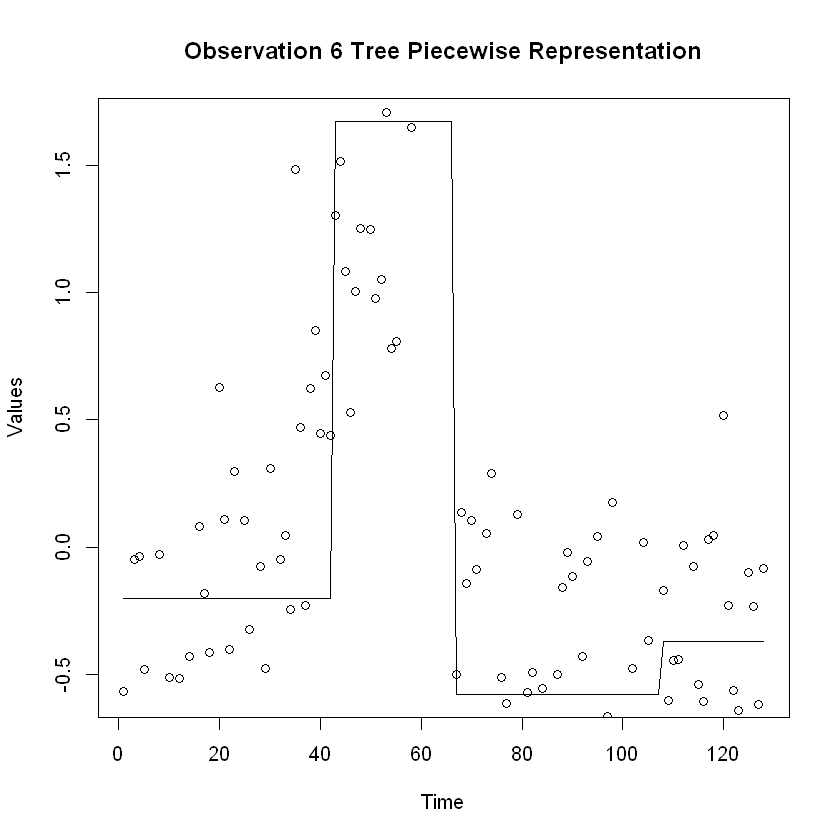

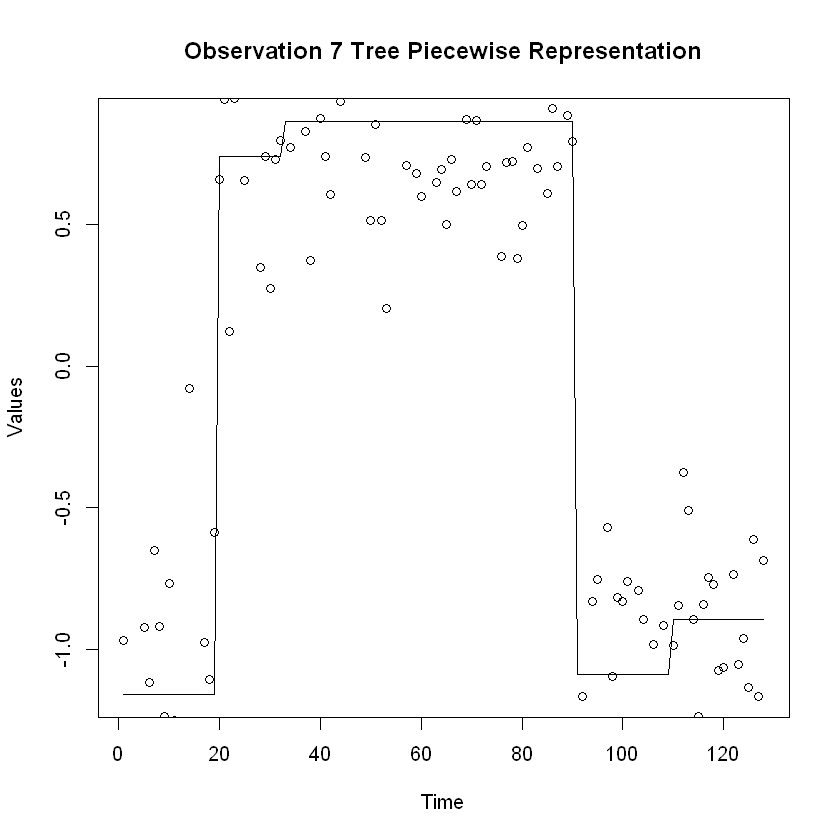

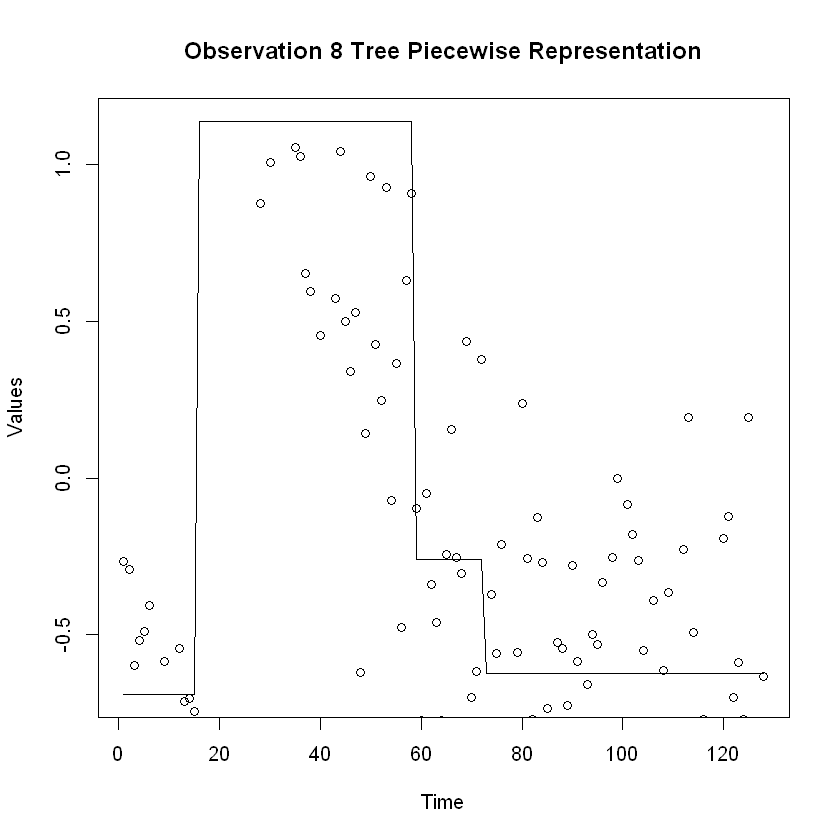

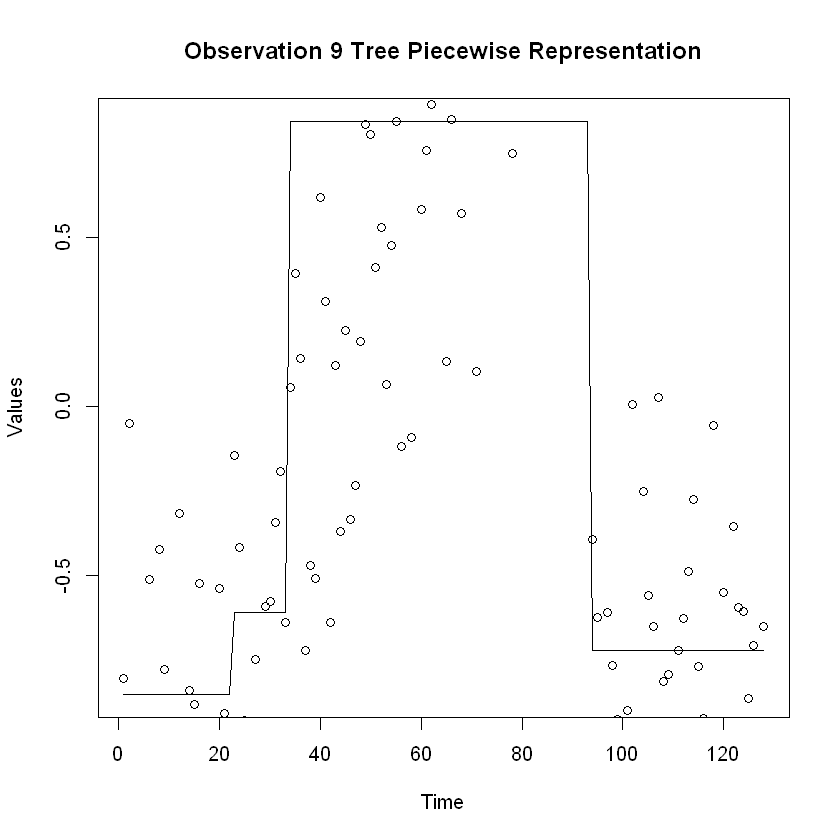

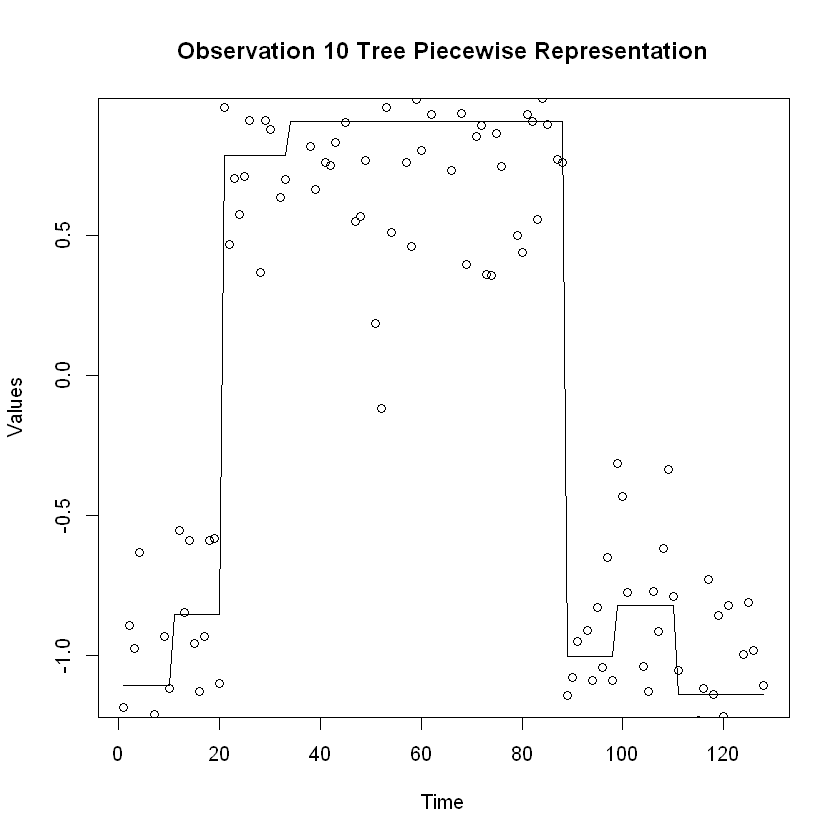

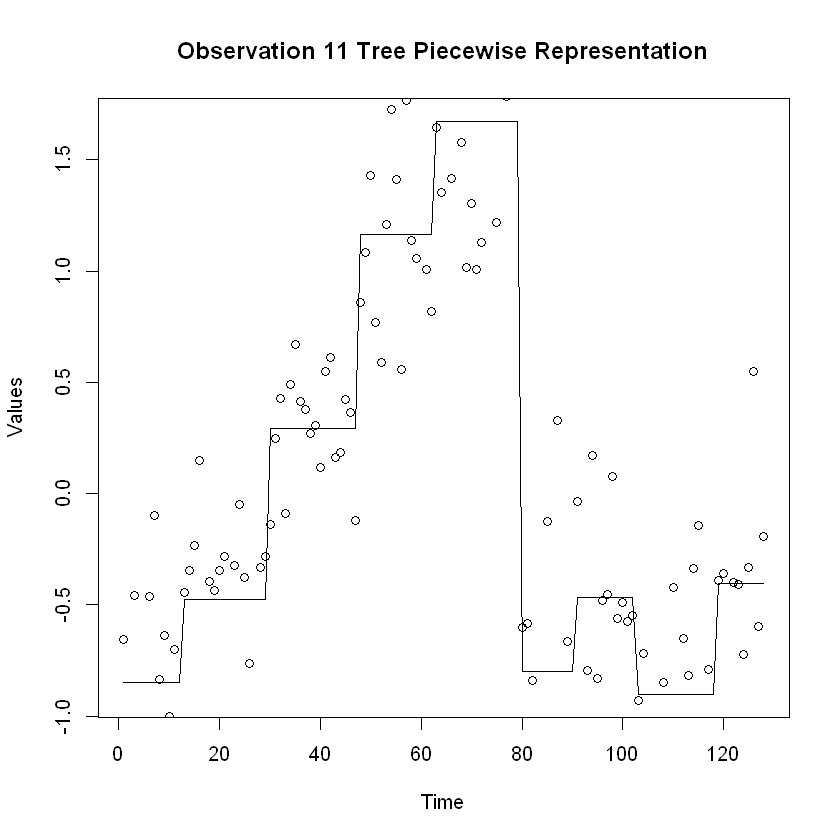

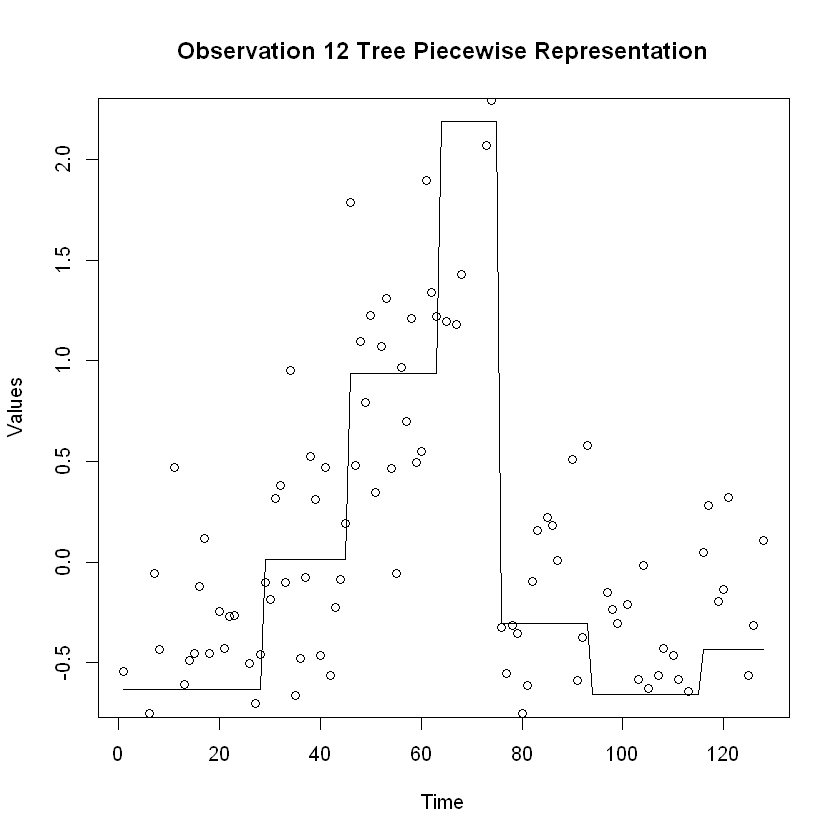

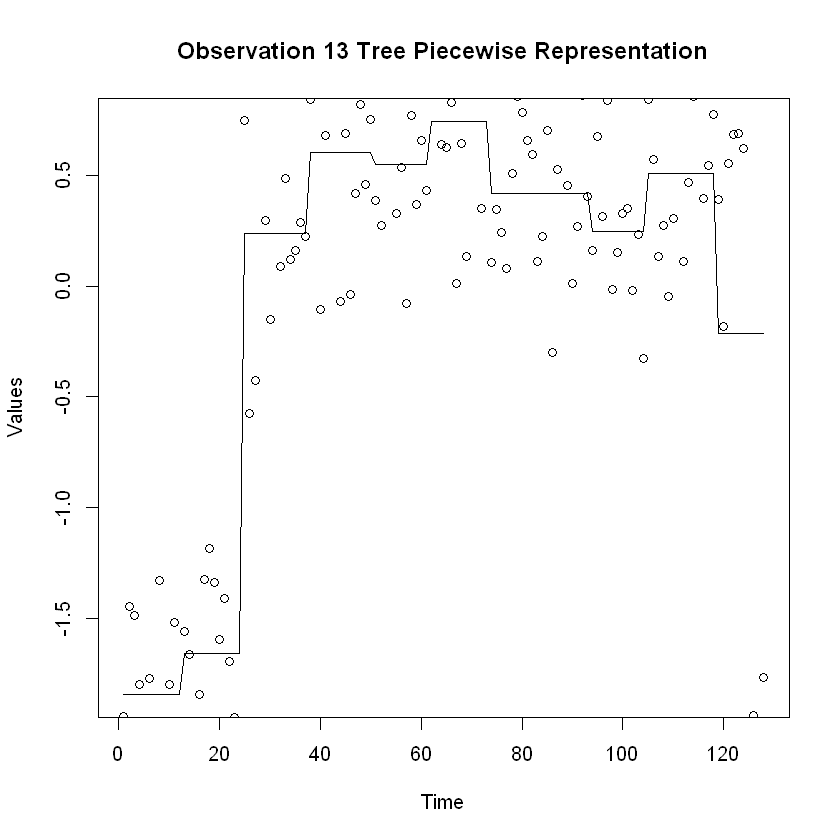

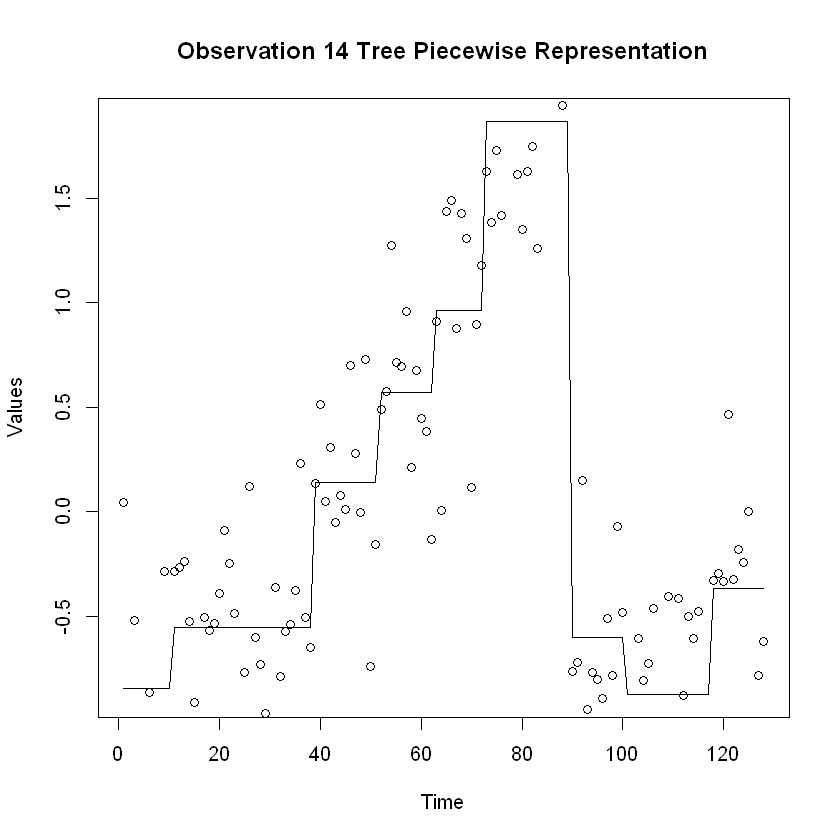

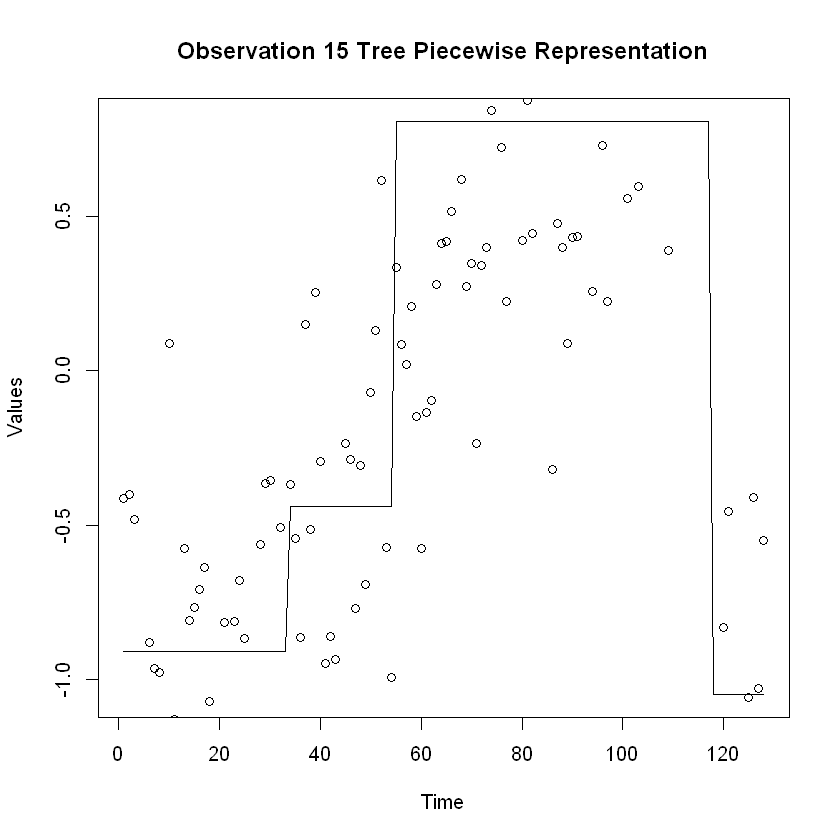

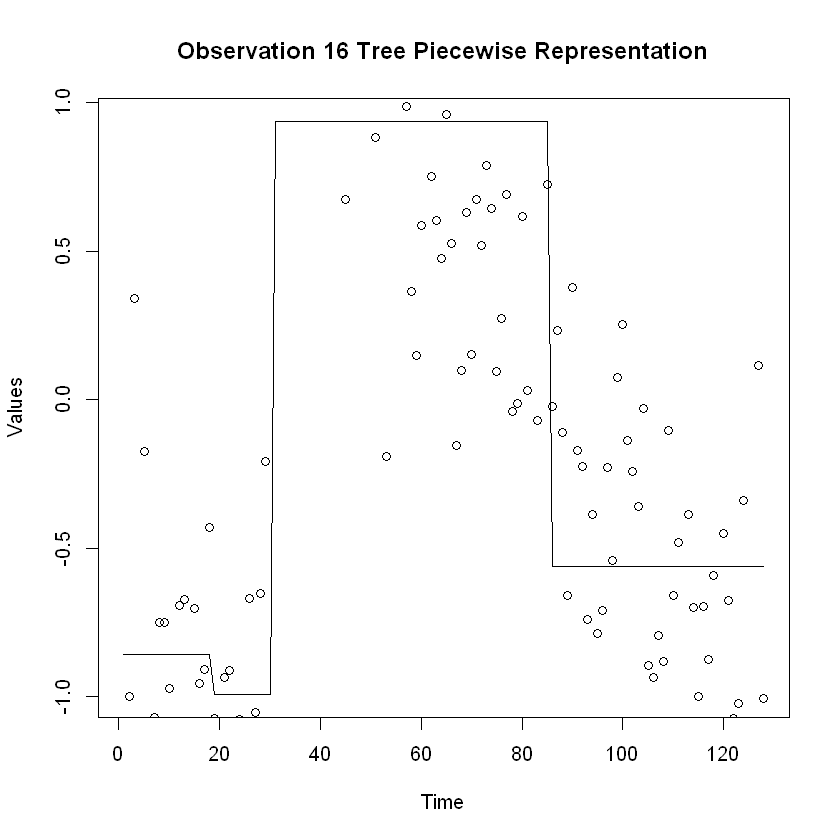

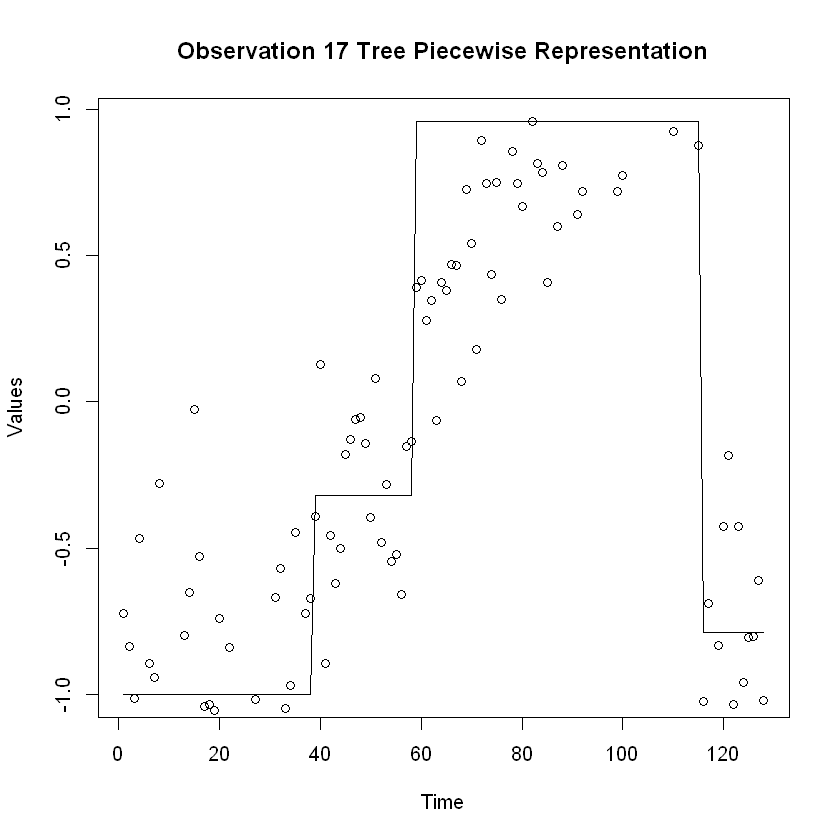

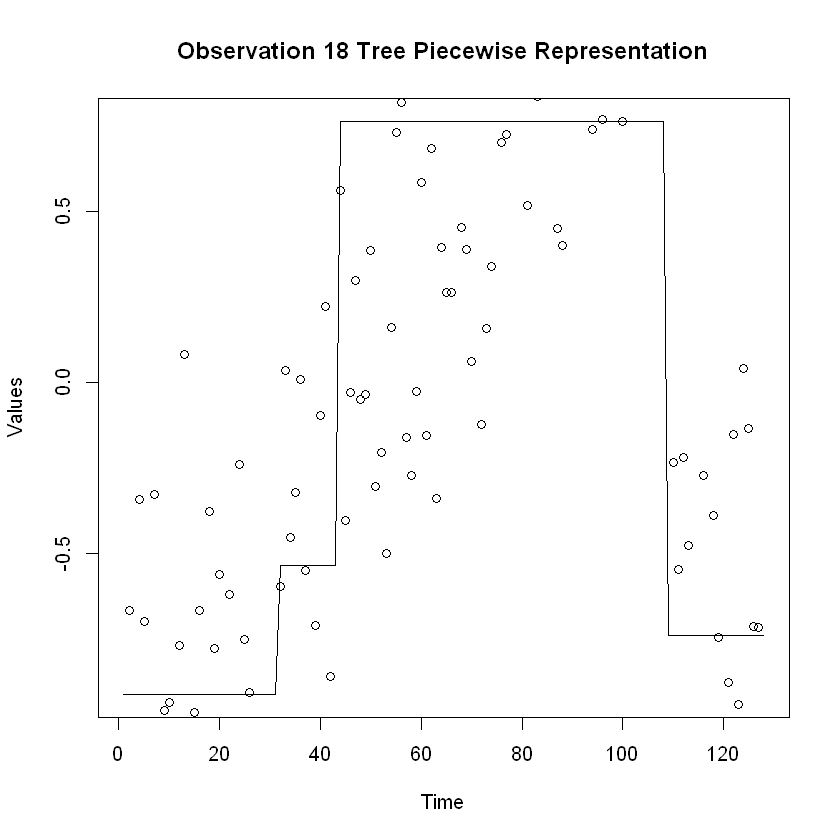

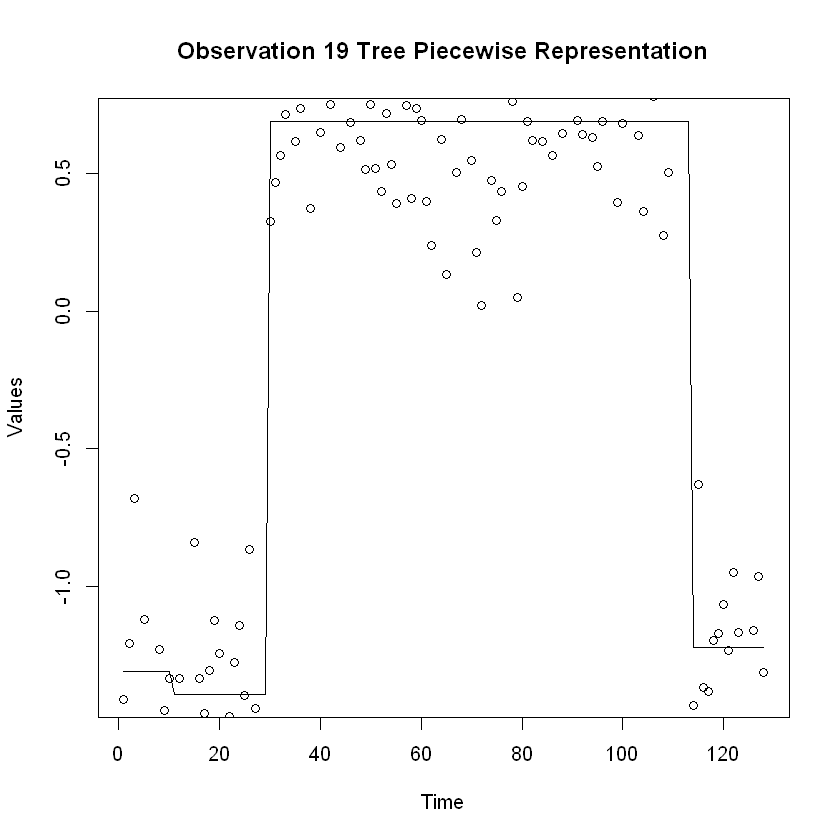

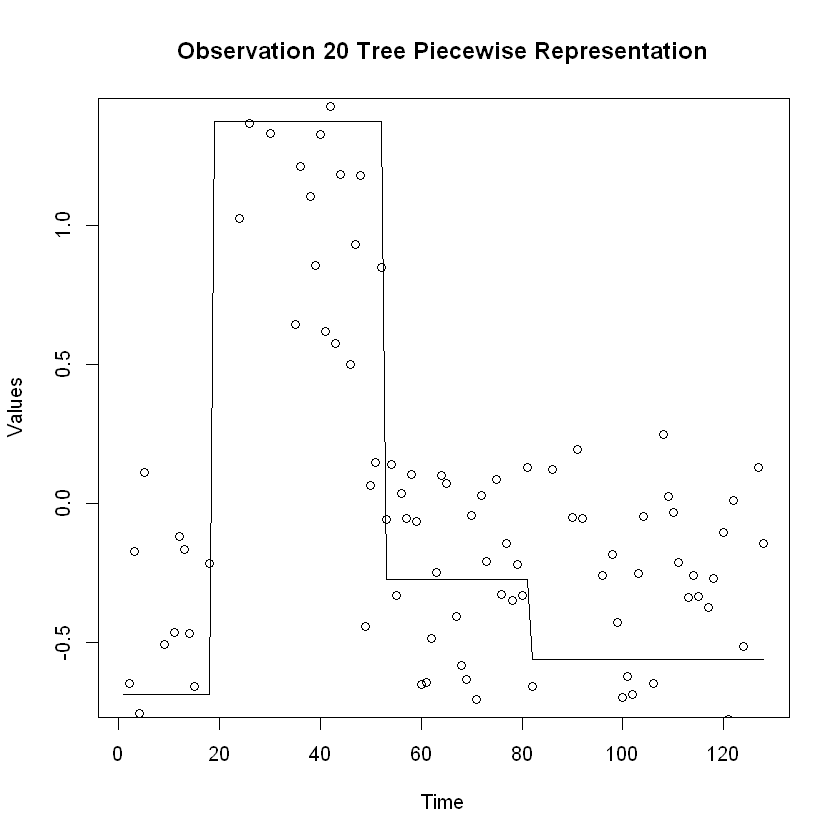

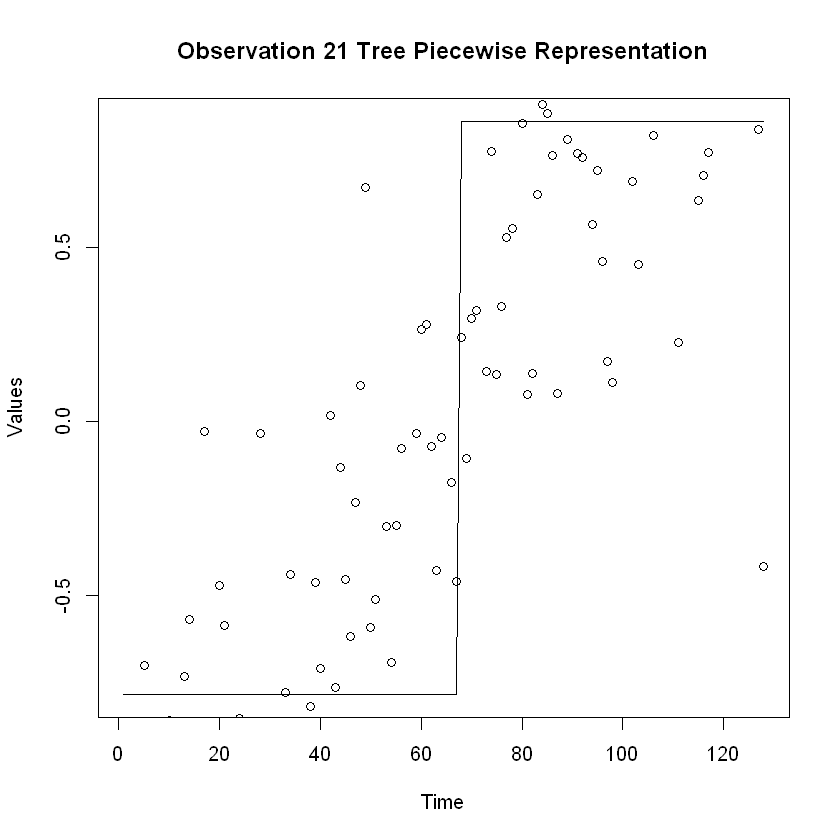

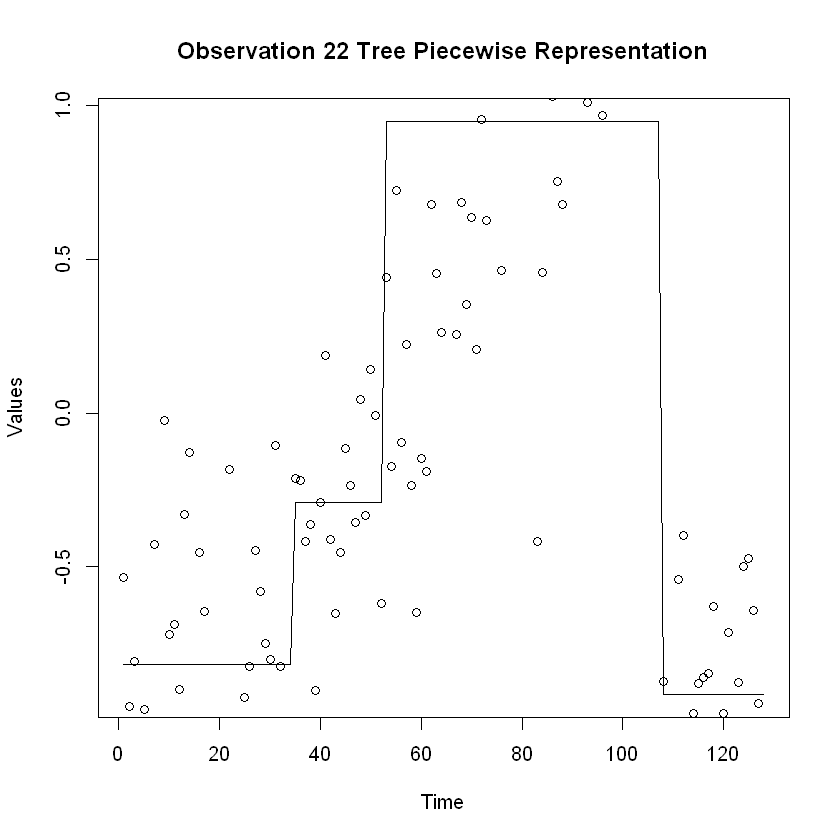

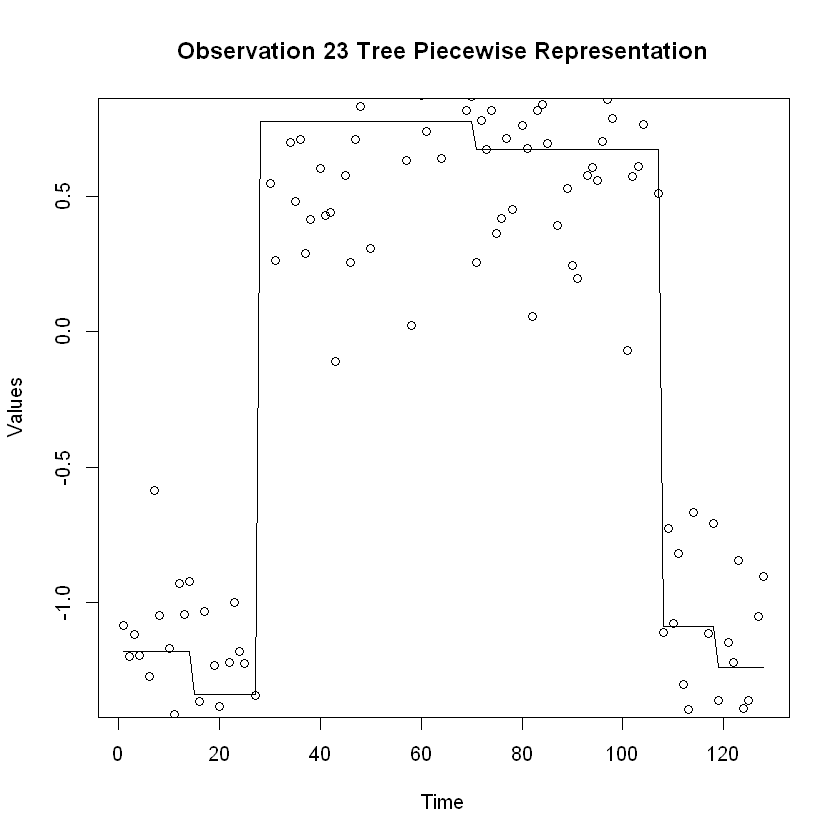

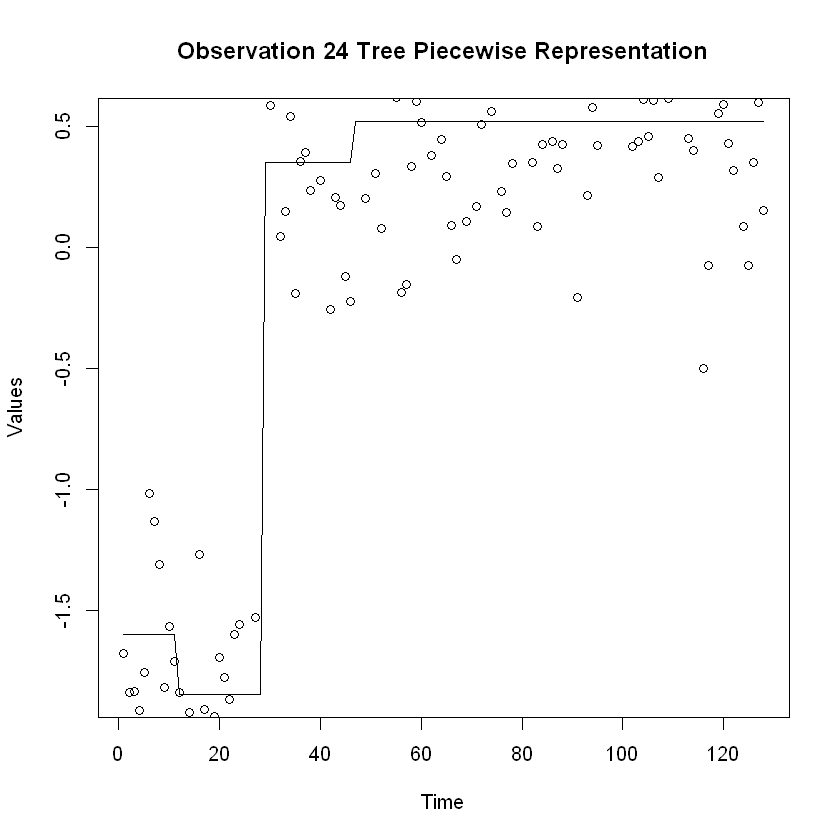

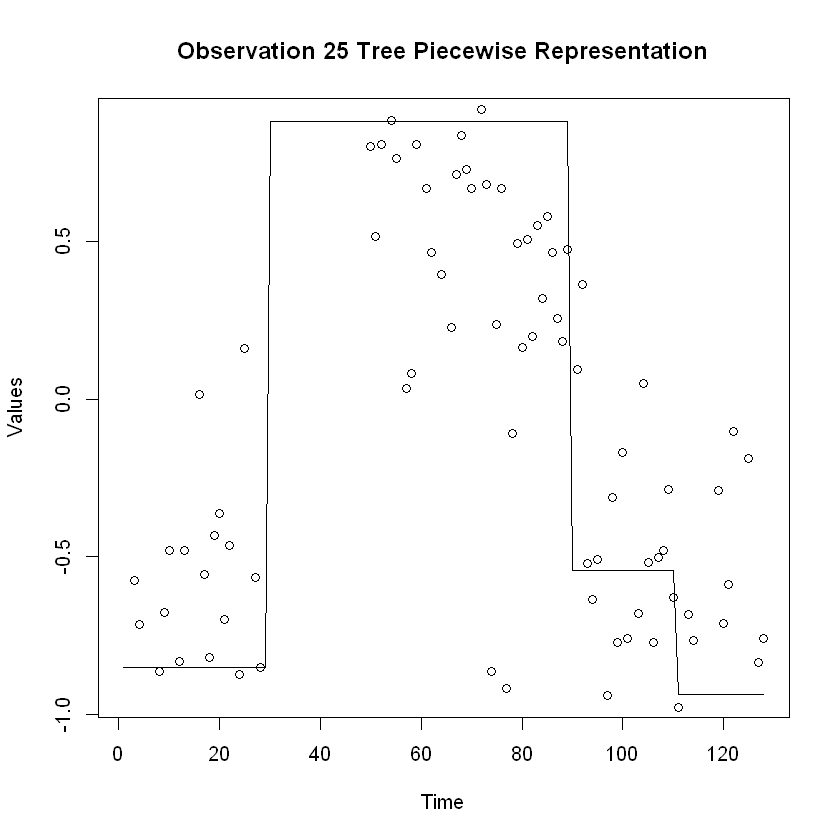

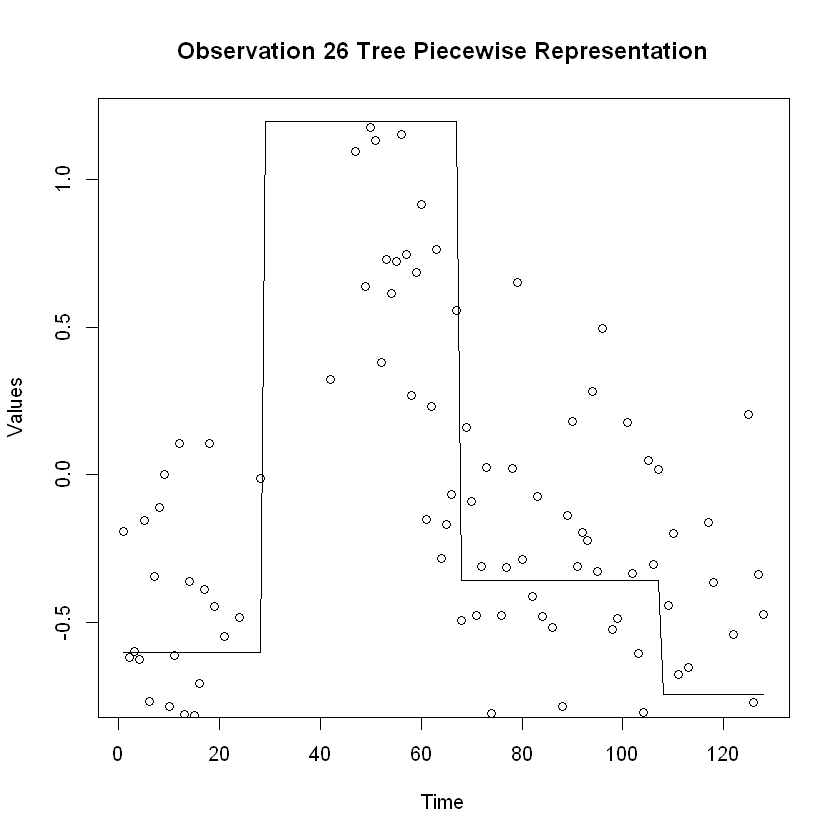

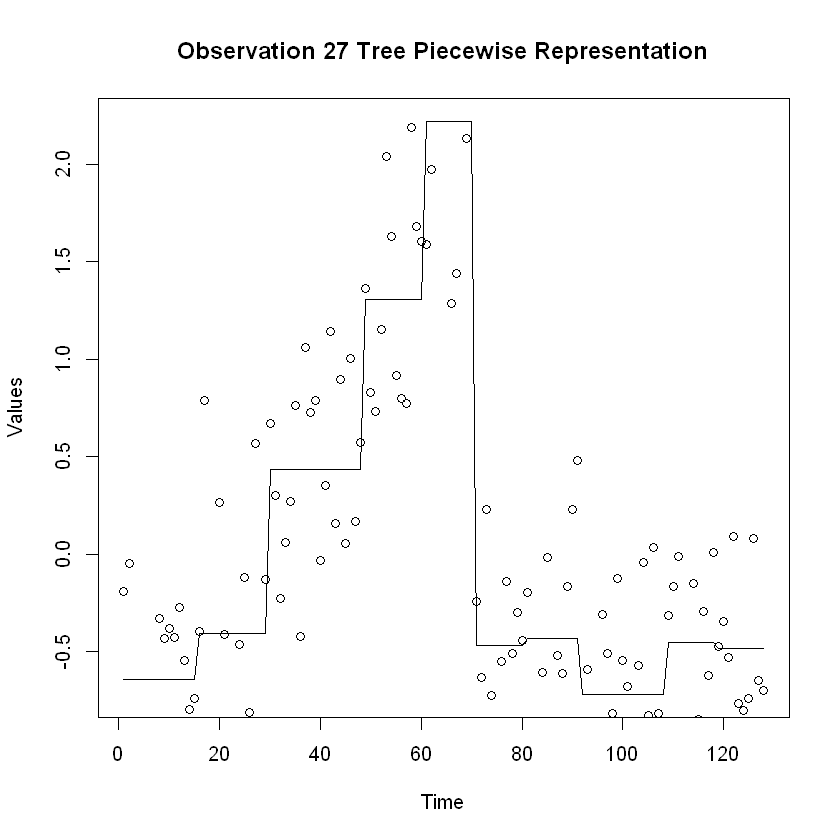

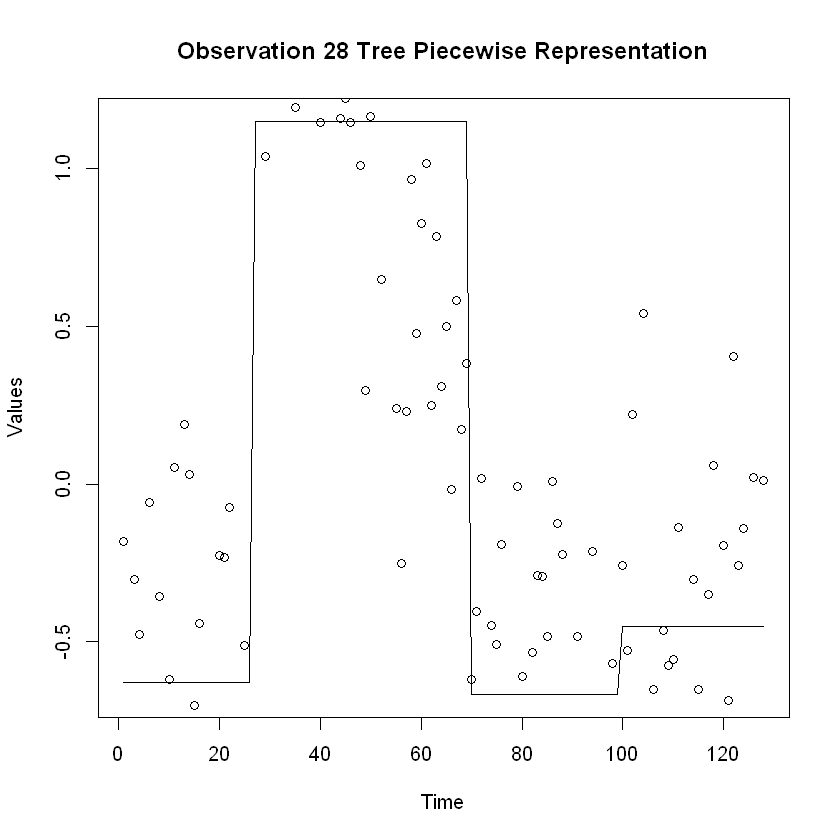

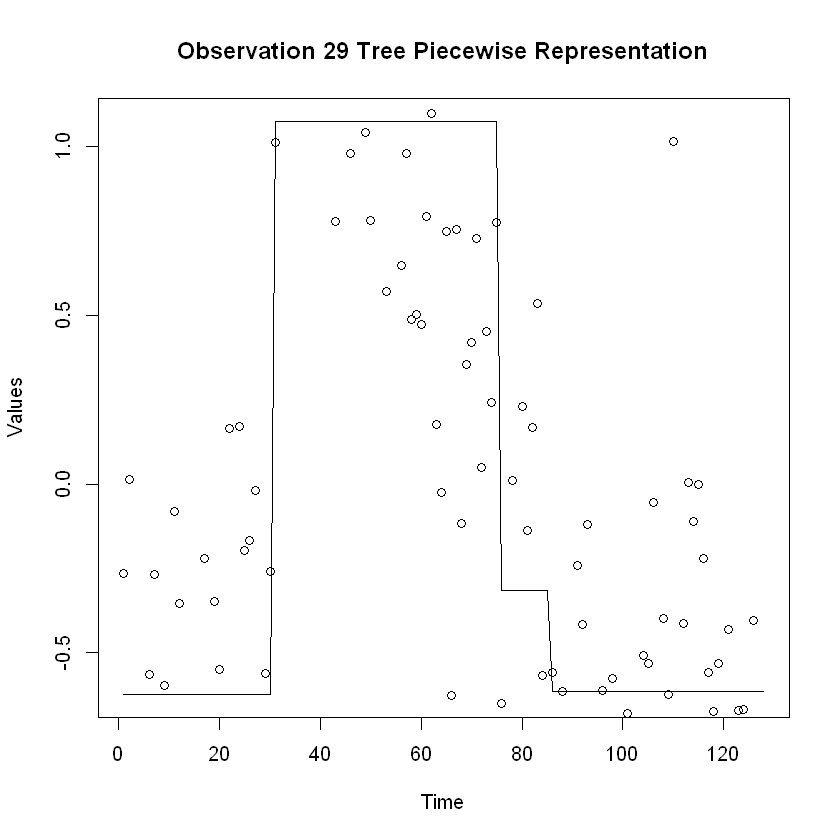

[[1]]
[1] 4

[[2]]
[1] 2

[[3]]
[1] 4

[[4]]
[1] 2

[[5]]
[1] 2

[[6]]
[1] 2

[[7]]
[1] 3

[[8]]
[1] 2

[[9]]
[1] 2

[[10]]
[1] 3

[[11]]
[1] 4

[[12]]
[1] 3

[[13]]
[1] 6

[[14]]
[1] 4

[[15]]
[1] 2

[[16]]
[1] 2

[[17]]
[1] 2

[[18]]
[1] 2

[[19]]
[1] 2

[[20]]
[1] 2

[[21]]
[1] 1

[[22]]
[1] 2

[[23]]
[1] 3

[[24]]
[1] 2

[[25]]
[1] 2

[[26]]
[1] 2

[[27]]
[1] 4

[[28]]
[1] 2

[[29]]
[1] 2

[[30]]
[1] 2



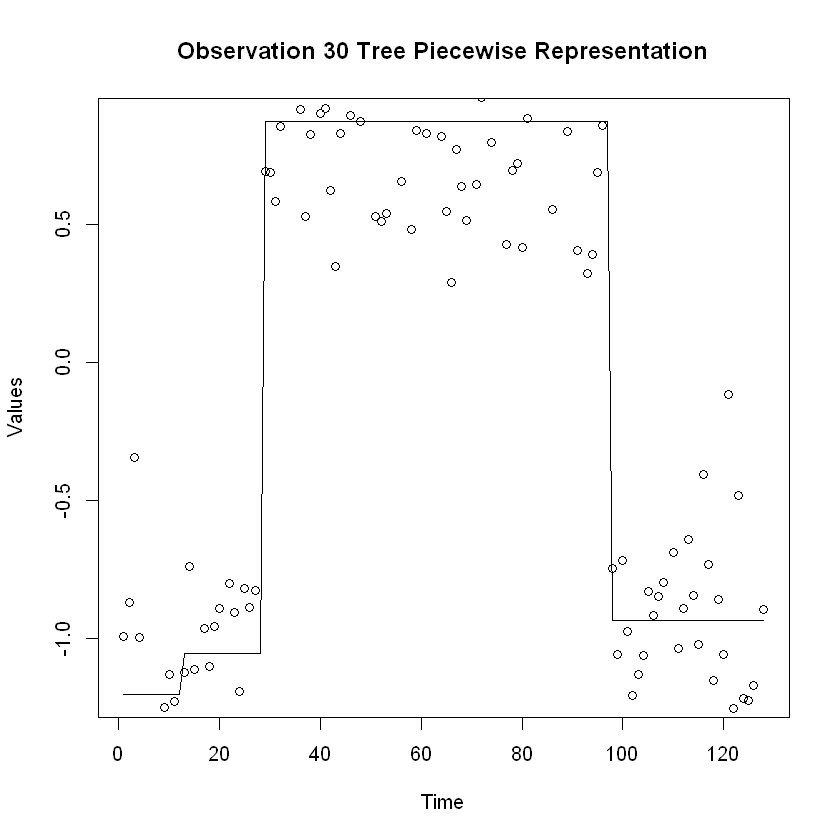

In [7]:
k_indexes = seq(1,121,10)
selected_depth <- list()

for (i in 1:30){
    error = 100
    for (j in 1:10){
        for(k in 0:9){
            model <- rpart(value~time, long_cbf_train[id==i & !(time %in% (k_indexes+k))], control=rpart.control(minsplit=20, minbucket=10, cp=0, maxdepth=j))
            predicted = as.numeric(predict(model,long_cbf_train[id==1 & (time %in% (k_indexes+k))]))
            if(mean((long_cbf_train[id==1 & (time %in% (k_indexes+k))]$value - predicted)^2)<error){
                error = mean((long_cbf_train[id==1 & (time %in% (k_indexes+k))]$value - predicted)^2)
                selected_depth[[i]] = j
            }
        }
    }
    model <- rpart(value~time, long_cbf_train[id==i], control=rpart.control(minsplit=20, minbucket=10, cp=0, maxdepth=selected_depth[[i]]))
    long_cbf_train[id == i,"predicted_tree"] = predict(model,long_cbf_train[id == i])
}

for ( i in 1:30){
    plot(long_cbf_train[id == i]$time,long_cbf_train[id == i]$predicted_tree,type = "l",xlab = "Time",ylab = "Values",
         main = paste("Observation",toString(i),"Tree Piecewise Representation"))
    points(long_cbf_train[id == i]$value)
}



    long_cbf_train[,MSE_tree:=mean((value-predicted_tree)^2),by = id]
    long_cbf_train[,MSE_lasso:=mean((value-predicted_lasso)^2),by = id]

    print(selected_depth)

#### 3-
When we compared mean squared error boxplots of lasso and regression tree representations, we can see that lasso method seems to have lower mse values which means it is more accurate than regression tree representation in this case

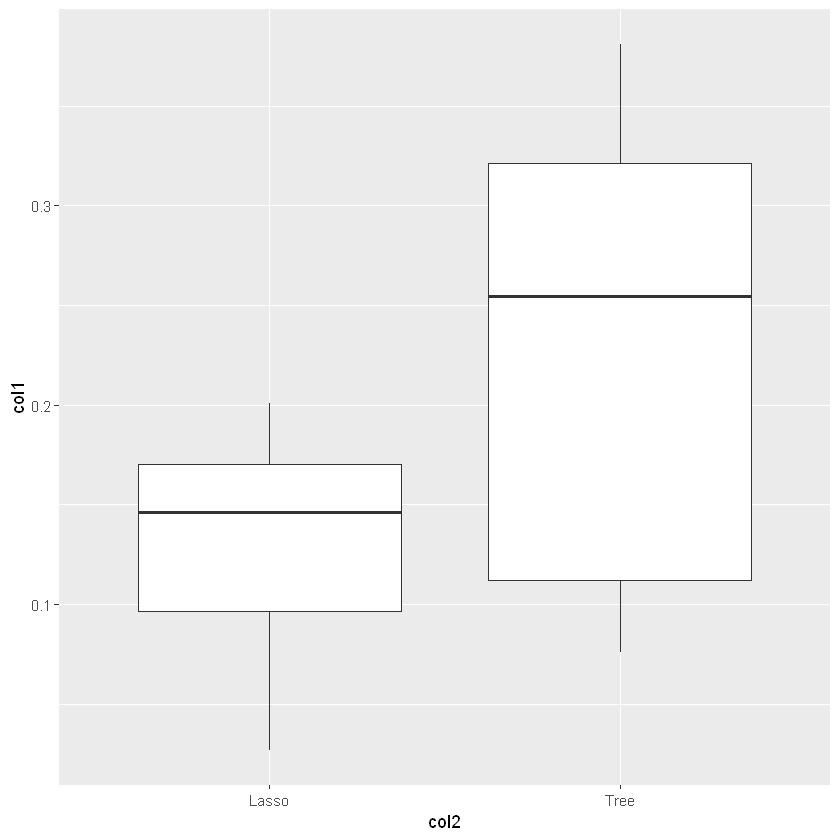

In [14]:
MSE_values <- data_frame(col1 = c(unique(long_cbf_train[,MSE_lasso]),unique(long_cbf_train[,MSE_tree])),
                        col2 = c(rep("Lasso",30),rep("Tree",30)))
ggplot(MSE_values, aes(x = col2, y = col1)) +            # Applying ggplot function
  geom_boxplot()

#### 4-
1NN prediction is performed for raw data and piecewise approaches.

In [9]:
cbf_train_with_tree_values <- data.table()
cbf_train_with_lasso_values <- data.table()
for(i in 1:128){
    cbf_train_with_tree_values[,paste("V",toString(i),sep = "")] = long_cbf_train[time == i]$predicted_tree
    cbf_train_with_lasso_values[,paste("V",toString(i),sep = "")] = long_cbf_train[time == i]$predicted_lasso
    
}

In [10]:
one_nearest_neighbor_classifier <- function(traindata){
euc_dist=dist(traindata)
euc_dist=as.matrix(euc_dist)
large_number=1000
diag(euc_dist)=large_number
neighborhood=order(euc_dist[1,])
neighborhood=apply(euc_dist,1,order) #first array entry is 1, why?
predicted=trainclass[neighborhood[1,]]
return(list(table(trainclass$class,predicted$class),sum(trainclass==predicted)/length(predicted$class)))
}

In [19]:
print("Raw Data Accuracy")
one_nearest_neighbor_classifier(traindata)

[1] "Raw Data Accuracy"


[[1]]
   
     1  2  3
  1  8  0  2
  2  1 11  0
  3  2  0  6

[[2]]
[1] 0.8333333


In [20]:
print("Tree Data Accuracy")
one_nearest_neighbor_classifier(cbf_train_with_tree_values)

[1] "Tree Data Accuracy"


[[1]]
   
    1 2 3
  1 7 0 3
  2 0 9 3
  3 1 0 7

[[2]]
[1] 0.7666667


In [21]:
print("Lasso Data Accuracy")
one_nearest_neighbor_classifier(cbf_train_with_lasso_values)

[1] "Lasso Data Accuracy"


[[1]]
   
     1  2  3
  1  8  0  2
  2  0 12  0
  3  0  0  8

[[2]]
[1] 0.9333333


As we see, in this case lasso approach have more accuracy than others and tree approach did not provide any improvement in my case. It may be because of poor validation and grid parameter setting.

To conclude, In knn classifying problems some penalized regression approaches or some piecewise representation approach may be useful. It is worth to try those methods.